In [ ]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install -e .

fatal: destination path 'transformers' already exists and is not an empty directory.
/content/transformers
Obtaining file:///content/transformers
  Found existing installation: transformers 3.0.2
    Can't uninstall 'transformers'. No files were found to uninstall.
  Running setup.py develop for transformers


### Connect to Google Drive

In [ ]:
from google.colab import drive

drive_name = '/content/drive'
drive.mount(drive_name)
drive_folder = ''
drive_location = drive_name + '/My Drive/' + drive_folder  # Change this to where your files are located

data_location = drive_location + '/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !cp /content/drive/'My Drive'/omega_train_notlong.npy .
# !cp /content/drive/'My Drive'/omega_val_long.npy .
# !cp /content/drive/'My Drive'/monomer*.npy .
# !cp /content/drive/'My Drive'/gpt_longer*.pt .
# !cp /content/drive/'My Drive'/gpt_monomer*.pt .
!cp /content/drive/'My Drive'/cath*.npy .

# !cp /content/drive/'My Drive'/all.tar.gz .
# !tar -xzf all.tar.gz
# !rm all.tar.gz
# !for f in *.tar.gz; do tar -xzf $f; rm $f; done

### Generate masked data

In [ ]:
#@title
class ProteinPipeline(FillMaskPipeline):
    def __init__(
        self,
        model: Union["PreTrainedModel", "TFPreTrainedModel"],
        tokenizer: PreTrainedTokenizer,
        modelcard: Optional[ModelCard] = None,
        framework: Optional[str] = None,
        args_parser: ArgumentHandler = None,
        device: int = -1,
        topk=5,
        task: str = "",
    ):
        super().__init__(
            model=model,
            tokenizer=tokenizer,
            modelcard=modelcard,
            framework=framework,
            args_parser=args_parser,
            device=device,
            binary_output=True,
            topk=topk,
            task=task,
        )

    def __call__(self, *args, **kwargs):
        inputs = self._parse_and_tokenize(*args, **kwargs)
        outputs = self._forward(inputs, return_tensors=True)

        results = []
        batch_size = outputs.shape[0] if self.framework == "tf" else outputs.size(0)

        for i in range(batch_size):
            input_ids = inputs["input_ids"][i]
            result = []

            masked_index = (input_ids == self.tokenizer.mask_token_id).nonzero()

            # Fill mask pipeline supports only one ${mask_token} per sample
            # self.ensure_exactly_one_mask_token(masked_index.numpy())

            logits = outputs[i, masked_index.item(), :]
            probs = logits.softmax(dim=0)
            values, predictions = probs.topk(self.topk)

            for v, p in zip(values.tolist(), predictions.tolist()):
                tokens = input_ids.numpy()
                tokens[masked_index] = p
                # Filter padding out:
                tokens = tokens[np.where(tokens != self.tokenizer.pad_token_id)]
                result.append(
                    {
                        "sequence": self.tokenizer.decode(tokens),
                        "score": v,
                        "token": p,
                        "token_str": self.tokenizer.convert_ids_to_tokens(p),
                    }
                )

            # Append
            results += [result]

        if len(results) == 1:
            return results[0]
        return results

In [ ]:
#@title
import numpy as np
import copy
# mask token id = 365
train_data = np.load("cath_train.npy", allow_pickle=True)
# val_data = np.load("cath_val.npy", allow_pickle=True)
print(train_data.shape)
p, l, d = train_data.shape
labels = np.zeros((p, l, d))
for i in range(p):
    end = 0
    for j in range(l):
        if train_data[i,j,0] == 364:
            end = j
            break

            # actually set 1-0.15 percent of sequence length to have index -100 
            # this is the label-- -100s are ignored, the rest is what the model needs to predict
            # mask out the rest in the input_ids
    num_to_mask = int(0.15*(end-1))   # probably should have the same mask indices per batch
                                      # use iteration number as random seed
    sample = np.random.choice(np.arange(1, end), replace=False, size=(num_to_mask,))
    print(sample)
    print(train_data[i,:end+1].flatten())
    labels = copy.deepcopy(train_data[i, sample])
    train_data[i, sample] = 365
    print(train_data[i,:end+1].flatten())


(27360, 478, 1)
[ 12 163  59 117  94   8   4 153  18  74  52  90  96  11 118 120 164  42
  35  24  75  78  22 131  87]
[363 110 141 355 115 136 356 127 131   3 117 136 356 116 139 356 116 138
   0 116 137 349 124 133 360 117 144 356 113 135 355 128 136 357 117 137
 357 123 131   2 114 144 357 116 138   2 102 139   9  47 260   7 121 160
   6  70 204 355 113 323   1  93 341 354 117 147   0 116 126 353 129 131
 357 118 139 357 120 136 355 119 127   4 125 135   5  81 180 360 233 227
 353  51 342 357 117 336 351 125 148 358 118 133 355 120 140   1 113 136
 353 125 132   0 117 139 353 124 128 358 121 140   2 119 132 352 123 139
   2 101 177   8 232 221 355  79 297   5 112 345 355 119 338  12 123 136
   2 114 146 356 110 138 357 122 138 357 118 127 355 126 133   2 116 133
   3 110 144 359 114 135 352 131 135 358 364]
[363 110 141 355 365 136 356 127 365   3 117 365 365 116 139 356 116 138
 365 116 137 349 365 133 365 117 144 356 113 135 355 128 136 357 117 365
 357 123 131   2 114 144 365 116

In [ ]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')
input_ids = tokenizer("Hello, my dog is cute", return_tensors="pt")["input_ids"]
print(tokenizer.mask_token_id)
print(input_ids)
outputs = model(input_ids, labels=input_ids)
loss, prediction_scores = outputs[:2]
print(loss)
print(prediction_scores)

## BERT

In [ ]:
import os
import glob
import numpy as np
import random
import time
import datetime
import logging
logging.basicConfig(level=logging.INFO)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
from torch.autograd import Variable
from transformers import RobertaForMaskedLM, RobertaConfig, AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
# % matplotlib inline
import seaborn as sns
import math

seed_val = 1234
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def to_var(tensor):
    return Variable(tensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Uncomment for training

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = np.load("cath_train.npy", allow_pickle=True)
train_data = train_data[:,:90] # get rid of unnecessary padding for speedup?
train_data = torch.from_numpy(np.array(train_data, dtype=np.int64))
train_dataset = TensorDataset(train_data)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

print("training length", len(train_dataloader), flush=True)

val_data = np.load("cath_val.npy", allow_pickle=True)
val_data = val_data[:,:90,:]
val_data = torch.from_numpy(np.array(val_data, dtype=np.int64))
val_dataset = TensorDataset(val_data)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)



INFO:transformers.file_utils:PyTorch version 1.6.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.3.0 available.


training length 855


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import copy
import math

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

config = RobertaConfig(
    vocab_size=366,
    hidden_size=216,
    intermediate_size=216*4,
    max_position_embeddings=514,
    num_attention_heads=2,
    num_hidden_layers=6,
    type_vocab_size=1,
)


def train_model(model=None, lr=None): #lr, eps

    b = 32
    

    if model is None:
        model = RobertaForMaskedLM(config)

    # model.load_state_dict(torch.load("gpt_longer_train.pt"))
    model.to(device)

    if lr is None:
        lr = 3e-4
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-6, 1e-5, cycle_momentum=False)
    num_epochs = 400
    total_steps = 27360/32 * num_epochs
    # scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                         num_warmup_steps = 0, #total_steps//5,
    #                                         num_training_steps = total_steps)
    impatience = 0
    mask_perc = 0.5  
    patience = 50
    train_loss = []
    best_loss = 1e7
    best_val_loss = 1e7
    val_loss = []
    loss_fn = nn.CrossEntropyLoss()

    pred_idx_onehot = torch.FloatTensor(b, 90)

    for epoch_i in range(0, num_epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs), flush=True)
        t0 = time.time()

        total_loss = 0
        model.train()

        train_steps = 0

        # random.seed(epoch_i)        # use iteration number as random seed
        # np.random.seed(epoch_i)
        # torch.manual_seed(epoch_i)
        # torch.cuda.manual_seed_all(epoch_i)

        for i, b_input_ids in enumerate(train_dataloader):
            batch = []
            for b in b_input_ids:
                batch.append(b.numpy())
            batch = np.array(batch).squeeze(axis=0)  
            b_input_ids = torch.from_numpy(batch)
            b_input_ids = b_input_ids.to(device)

            b_input_ids = b_input_ids.type(torch.LongTensor).squeeze().to(device)
            attn_mask = b_input_ids != 362
            b = b_input_ids.shape[0]
            masks = np.concatenate((np.zeros((b,30)), np.ones((b,30)), np.zeros((b,30))), axis=1)
            masks = torch.from_numpy(np.array(masks)).type(torch.BoolTensor)
            
            labels = copy.deepcopy(b_input_ids)
            labels[~masks] = -100
            b_input_ids[masks] = 365
            model.zero_grad()
            loss = 0
            for _ in range(30):
                outputs = model(input_ids=b_input_ids, attention_mask=attn_mask,
                                output_attentions=True, labels=labels)
                preds = outputs[1]
                pred_max = torch.max(preds, dim=-1)
                pred_max_arg = pred_max[1]
                pred_max = pred_max[0]
                pred_max[~masks] = -math.inf
                pred_idx = torch.argmax(pred_max, dim=1)
                pred_idx_onehot.zero_()
                pred_idx_onehot.scatter_(1, pred_idx.view(-1,1).cpu(), 1)
                pred_idx_onehot = pred_idx_onehot.type(torch.BoolTensor)
                # import IPython ; IPython.embed() ; exit(1)
                p = preds[pred_idx_onehot,:]
                la = labels[pred_idx_onehot]
                loss_step = loss_fn(p, la)
                loss_step.backward()
                optimizer.step()
                
                loss += loss_step.item()
                b_input_ids[pred_idx_onehot] = copy.deepcopy(labels[pred_idx_onehot])
                masks = masks ^ pred_idx_onehot
                # print("masks", masks[0])
                labels[~masks] = -100
            train_steps += 1
            total_loss += loss
            scheduler.step()
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch_i + 1,
                    num_epochs,
                    i + 1,
                    total_steps,
                    loss), flush=True
                  )

        avg_train_loss = total_loss / train_steps
        train_loss.append(avg_train_loss)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            torch.save(model.state_dict(), "gpt_cath_train.pt")

        print("  Training epoch took: {:}".format(format_time(time.time() - t0)), flush=True)
        print("  Training loss: {0:.2f}".format(avg_train_loss), flush=True)
train_loss, val_loss, _ = train_model()
plot_loss(train_loss, val_loss)

======== Epoch 1 / 400 ========
Epoch [1/400], Step [100/342000.0], Loss: 158.1825
Epoch [1/400], Step [200/342000.0], Loss: 151.4453
Epoch [1/400], Step [300/342000.0], Loss: 153.9810
Epoch [1/400], Step [400/342000.0], Loss: 148.6810
Epoch [1/400], Step [500/342000.0], Loss: 142.0952
Epoch [1/400], Step [600/342000.0], Loss: 147.1146
Epoch [1/400], Step [700/342000.0], Loss: 138.7218
Epoch [1/400], Step [800/342000.0], Loss: 136.3511
  Training epoch took: 0:41:33
  Training loss: 149.03
======== Epoch 2 / 400 ========
Epoch [2/400], Step [100/342000.0], Loss: 136.2192
Epoch [2/400], Step [200/342000.0], Loss: 132.0952
Epoch [2/400], Step [300/342000.0], Loss: 126.6120
Epoch [2/400], Step [400/342000.0], Loss: 126.6332
Epoch [2/400], Step [500/342000.0], Loss: 132.5422
Epoch [2/400], Step [600/342000.0], Loss: 122.0227
Epoch [2/400], Step [700/342000.0], Loss: 125.6309
Epoch [2/400], Step [800/342000.0], Loss: 117.6187
  Training epoch took: 0:41:37
  Training loss: 128.33
======== E

KeyboardInterrupt: ignored

In [ ]:
import torch

def masked_max(tensor, mask, dim):
    """Finding the max along dim"""
    masked = torch.mul(tensor, mask)
    neg_inf = torch.zeros_like(tensor)
    neg_inf[~mask] = -math.inf  # Place the smallest values possible in masked positions
    return (masked + neg_inf).max(dim=dim)

a = torch.randn(3,3)
print(a)
mask = torch.diag(torch.ones(3)).type(torch.BoolTensor)
print(masked_max(a, mask, 1))

# batch_size = 5
# nb_digits = 10
# # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
# y = torch.LongTensor(batch_size,1).random_() % nb_digits
# # One hot encoding buffer that you create out of the loop and just keep reusing
# y_onehot = torch.FloatTensor(batch_size, nb_digits)

# # In your for loop
# y_onehot.zero_()
# y_onehot.scatter_(1, y, 1)

# print(y)
# print(y_onehot)

In [ ]:
 # import IPython ; IPython.embed() ; exit(1)
                if not np.isnan(loss.item()):
                    train_steps += 1
                    curr_loss = loss.item() 
                    
                    total_loss += curr_loss
                    # t1 = time.time()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    # print("backward pass took {:}".format(format_time(time.time() - t1)))
                    optimizer.step()
                    scheduler.step()
                    if (i + 1) % 100 == 0:
                        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                            epoch_i + 1,
                            num_epochs,
                            i + 1,
                            total_steps,
                            loss.item()), flush=True
                          )

            avg_train_loss = total_loss / train_steps
            train_loss.append(avg_train_loss)

            if avg_train_loss < best_loss:
                best_loss = avg_train_loss
                torch.save(model.state_dict(), "gpt_cath_train.pt")

            print("  Training epoch took: {:}".format(format_time(time.time() - t0)), flush=True)
            print("  Training loss: {0:.2f}".format(avg_train_loss), flush=True)

            print("Running Validation...", flush=True)

            model.eval()

            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0

            for i, b_input_ids in enumerate(val_dataloader):
                batch = []
                for b in b_input_ids:
                    batch.append(b.numpy())
                batch = np.array(batch).squeeze(axis=0)
                b_input_ids = torch.from_numpy(batch)
                b_input_ids = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().to(device)
                attn_mask = b_input_ids != 362
                b, l = b_input_ids.shape
                b, l = b_input_ids.shape
                idx = b_input_ids[0] == 362
                masks = torch.from_numpy(np.array(masks).squeeze()).type(torch.BoolTensor)
                cmask = masks[:b]
                labels = copy.deepcopy(b_input_ids)
                labels[~cmask] = -100
                b_input_ids[cmask] = 365
                with torch.no_grad():
                    outputs = model(input_ids=b_input_ids, attention_mask=attn_mask, labels=labels)
                curr_val_loss = outputs[0]
                if not np.isnan(curr_val_loss.item()):
                    eval_loss += curr_val_loss.item() #/ seq_len
                    nb_eval_steps += 1

            if eval_loss < best_val_loss:
                best_val_loss = eval_loss
                torch.save(model.state_dict(), "gpt_cath_val.pt")
            else:
                impatience += 1
            avg_val_loss = eval_loss/nb_eval_steps
            val_loss.append(avg_val_loss)
            print("  Validation loss: {0:.2f}".format(avg_val_loss), flush=True)

        print("Training complete.", flush=True)
    except KeyboardInterrupt:
        print("Early exit from training.", flush=True)
        torch.save(model.state_dict(), "last_backprop.pt")
        return train_loss, val_loss, best_val_loss
    return train_loss, val_loss, best_val_loss


def plot_loss(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(train_loss, 'b-o')
    plt.plot(val_loss, 'r-o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("gpt_cath.png", dpi=200)

In [ ]:
import numpy as np
import glob
import random
random.seed(334)
files = glob.glob("*phi_psi_normed.npy")
print("Number of npy files: ", len(files))
random.shuffle(files)
train = np.zeros((124544, 302, 4))
test = np.zeros((31132, 302, 4))
def sort_func(path):
	a = np.load(path)
	return len(a)
files = sorted(files, key=sort_func)
for i, f in enumerate(files):
	if i % 100 == 0:
		print(f)
	a = np.load(f)
	if len(a) > 301:
		a = a[:301]
	diff = 302 - len(a)
	pad = np.zeros((diff, 4))
	pad.fill(200.)
	if i < 124544:
		train[i] = np.concatenate((a, pad), axis=0)
	else:
		i -= 124544
		test[i] = np.concatenate((a, pad), axis=0)

np.save("rcsb_train.npy", train)
np.save("rcsb_test.npy", test)

In [ ]:
!cp cath*.npy /content/drive/'My Drive'/
# !cp /content/drive/'My Drive'/rcsb* .

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import math

batch_size = 32
train_data = np.load("omega_train_notlong.npy", allow_pickle=True)[40000:40001]
train_data = train_data[:,-154:,:]
b, l, d = train_data.shape
# mask = train_data == 0
# train_data = ma.array(train_data, mask=mask)

train_circle = np.zeros((b, l, 7))    # two for each dihedral angle (2*3), one for labels
#shift and normalize coordinates
for i in [1, 2, 3]:
    train_data[:,:,i] = (train_data[:,:,i]*(2*math.pi) - math.pi)#/math.pi*180.
    # import IPython ; IPython.embed() ; exit(1)
    train_circle[:,:,2*i-1] = np.cos(train_data[:,:,i])     # cos(theta)
    train_circle[:,:,2*i] = np.sin(train_data[:,:,i])       # sin(theta)
    jitter = 0.01*np.random.randn(l)
    # print(jitter)
    x = jitter + train_circle[:,:,2*i-1].squeeze()
    y = jitter + train_circle[:,:,2*i].squeeze()
    # print(y.shape)
    t = range(l)
    plt.rcParams["figure.figsize"] = (4,4)
    plt.scatter(x, y, marker="o", c=t, cmap='inferno', alpha=0.5)

    plt.show()


In [ ]:
import numpy as np
a = np.load("cath_train.npy")
print(a.shape)
print(a[0,:5,0])
idx = a[:,:,0] == 0
print(idx.shape)
lengths = (478 - np.sum(idx, axis=1))/3
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)

### Reconstruct Cartesians from $\phi, \psi, \omega$

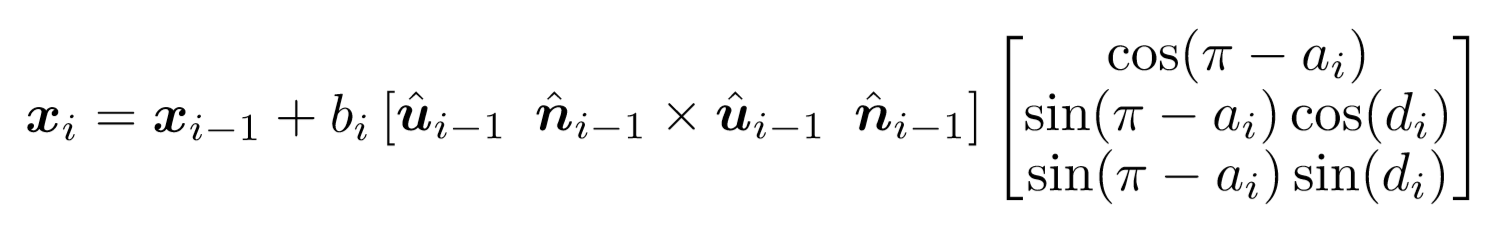

In [ ]:
import torch

def internal_to_cartesian(d):
    """d is a batch of dihedral angle lists (phi, psi, omega, ...)
    """
    b, l = d.shape
    d = d[:,1:]   # remove start token

    avg_bi = torch.tensor([1.4767849802009276, 1.5304241820059619, 1.3745557055222564])
    avg_ai = torch.tensor([1.928185608459926, 2.0245301864137275, 2.0980380385731374])
    bi = avg_bi.repeat(int(l/3)+2)
    ai = avg_ai.repeat(int(l/3)+2)

    x = torch.zeros(b, l+3, 3)
    x[:,0] = torch.tensor([0., 0., 0.])
    x[:,1] = torch.tensor([avg_bi[0], 0., 0.])
    x[:,2] = torch.tensor([avg_bi[0]+0.5354, 1.4337, 0.])

    for i in range(3, len(x)):
        vec_1 = x[:,i-1] - x[:,i-2]
        ui_1 = vec_1 / torch.norm(vec_1, dim=1)
        vec_2 = x[i-2] - x[i-3]
        ui_2 = vec_2 / torch.norm(vec_2, dim=1)
        cross = torch.cross(ui_2, ui_1, dim=1)
        ni_1 = cross / torch.norm(cross, dim=1)
        mat = torch.cat((ui_1.view(b,3,1), torch.cross(ni_1, ui_1).view(b,3,1), ni_1.view(b,3,1)), dim=2)
        
        vec = torch.tensor([math.cos(math.pi - ai[i-2])*torch.ones(b,1), math.sin(math.pi - ai[i-2])*math.cos(d[:,i-3]), math.sin(math.pi - ai[i-2])*math.sin(d[:,i-3])]).view(b,3,1)
        # import IPython ; IPython.embed() ; exit(1)
        x[:,i] = x[:,i-1] + bi[i-1]*torch.bmm(mat, vec)

    return x

x = internal_to_cartesian(b_input_ids)
bx, lx, dx = x.shape
rows = x.repeat_interleave(lx, dim=1)
cols = x.repeat(lx, 1)
dists = torch.norm(cols - rows, dim=3).view(b,l,l)

### Encourage more contacts

In [ ]:
#@title
def augmented_loss(x, c, r):
    """ Given the Cartesian coordinates, returns contact and repulsion losses
        weighed by c and r respectively
    """
    # import IPython ; IPython.embed() ; exit(1)
    l, d = x.shape
    rows = x.repeat_interleave(l, dim=0)
    cols = x.repeat(l, 1)
    dists = torch.norm(cols - rows, dim=1).view(l,l)
    # mask distances within two atoms away
    ones = torch.ones(l,l)
    mask = torch.tril(ones, -3) + torch.triu(ones, 3)
    dists = dists * mask
    dists_capped = torch.clamp(dists, 4.3, 6.)
    energy = 0.01*((2/(dists_capped-3))**12 - 2*(2/(dists_capped-3))**6)
    return c*(torch.sum(dists)) #+ r*(torch.sum(energy))


### Contact statistics of training data

In [ ]:
#@title
stats = []

for i, b_input_ids in enumerate(train_dataloader):
    # batch = []
    # for b in b_input_ids:
    #     batch.append(b.numpy())
    # batch = np.array(batch).squeeze(axis=0) 
    # b_input_ids = torch.from_numpy(batch)
    for b in b_input_ids:
        start = 0
        for i, s in enumerate(b):
          if (abs(abs(s[0])-1) < 0.01) and abs(s[1]) < 0.01:
              continue
          start = i
        b = b[start:]
        if len(b) > 5:
            cos = b[:,0].squeeze()
            sin = b[:,1].squeeze()
            angles = torch.atan2(sin, cos)
            x = internal_to_cartesian(angles)
            stats.append(augmented_loss(x, 1., 0.))

import seaborn as sns
sns.distplot(stats, kde=False)

In [ ]:
!git clone https://github.com/nicola-decao/power_spherical.git
%cd power_spherical
!python setup.py install

In [ ]:
class GPT_Protein(GPT2LMHeadModel):
    def __init__(self, config):
        super(GPT_Protein, self).__init__(config)
        self.transformer = MyDataParallel(self.transformer)

In [ ]:
#@title
import math
import torch
import matplotlib.pyplot as plt
from power_spherical import PowerSpherical

loc = torch.tensor([[[0., 1.], [1., 0.]], [[0., 1.], [1., 0.]]], requires_grad=True)
scale = torch.tensor([100., 100., 100., 100.], requires_grad=True)
dist = PowerSpherical(loc, scale)
print(dist.rsample())

# step_size = .001
# x = torch.arange(0, 2 * math.pi, step_size)
# pt = torch.stack((torch.cos(x), torch.sin(x))).t()
# y = torch.exp(dist.log_prob(pt)).detach()
# plt.plot(x, y, label='$p_X$')
# print('integal:', y.sum() * step_size)

# x = dist.sample((1000,))
# plt.hist((lambda v: torch.where(v > 0, v, 2 * math.pi + v))(torch.atan2(x[:,1], x[:,0])),
#          density=True, bins=50, alpha=.3, label='samples')

# print('grad:', torch.autograd.grad(dist.rsample() @ torch.tensor([math.sqrt(2) / 2, math.sqrt(2) / 2]),
#                                    [dist.loc, dist.scale]))

# plt.legend()
# plt.show()

### Self Attention

In [ ]:
#@title
import os
import glob
import numpy as np
import random
import time
import datetime
import logging
logging.basicConfig(level=logging.INFO)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
from torch.autograd import Variable
from transformers import GPT2LMHeadModel, GPT2Config, AdamW
from transformers import TransfoXLLMHeadModel, TransfoXLConfig
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
# % matplotlib inline
import seaborn as sns
import math

seed_val = 1234
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def to_var(tensor):
    return Variable(tensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Uncomment for training

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy.ma as ma
batch_size = 32
train_data = np.load("monomer_train.npy", allow_pickle=True)[:28992]  #[:40384-5024]    [:64]
# train_data = train_data[:,-154:,:]
b, l, d = train_data.shape
# mask = train_data == 0
# train_data = ma.array(train_data, mask=mask)

train_circle = np.zeros((b, l, 7))    # two for each dihedral angle (2*3), one for labels
#shift and normalize coordinates
for i in [1, 2, 3]:
    train_data[:,:,i] = (train_data[:,:,i]*(2*math.pi) - math.pi)#/math.pi*180.
    # import IPython ; IPython.embed() ; exit(1)
    train_circle[:,:,2*i-1] = np.cos(train_data[:,:,i])     # cos(theta)
    train_circle[:,:,2*i] = np.sin(train_data[:,:,i])       # sin(theta)
    # train_circle[:,:,2*i-1] = (train_circle[:,:,2*i-1] - np.mean(train_circle[:,:,2*i-1])) / np.std(train_circle[:,:,2*i-1])
    # train_circle[:,:,2*i] = (train_circle[:,:,2*i] - np.mean(train_circle[:,:,2*i])) / np.std(train_circle[:,:,2*i])

# flatten the dihedrals
train_circle[:,:,0] = train_data[:,:,0]
train_circle_coords = train_circle[:,:,1:].reshape(b, l*3, 2)
# train_circle_coords[train_circle_coords < 1e-2] = 0.
train_circle_labels = np.expand_dims(np.repeat(train_circle[:,:,0], 3, axis=1), -1)
train_data = np.concatenate((train_circle_labels, train_circle_coords), axis=2)

# train_data.mask = ma.nomask
# train_data = train_data.reshape(b, l, d)

train_data = torch.from_numpy(np.array(train_data, dtype=np.float32))
train_dataset = TensorDataset(train_data)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
print("training length", len(train_dataloader), flush=True)
val_data = np.load("monomer_test.npy", allow_pickle=True)[:448]   #[40384-5024:40384]     #[64:128]
# val_data = val_data[:,-154:,:]
b, l, d = val_data.shape
# mask = val_data == 0
# val_data = ma.array(val_data, mask=mask)

val_circle = np.zeros((b, l, 7))    # two for each dihedral angle (2*3), one for labels
#shift and normalize coordinates
val_mean_std = []
for i in [1, 2, 3]:
    val_data[:,:,i] = (val_data[:,:,i]*(2*math.pi) - math.pi)#/math.pi*180.

    val_circle[:,:,2*i-1] = np.cos(val_data[:,:,i])     
    val_circle[:,:,2*i] = np.sin(val_data[:,:,i])
    # val_mean_std.append(np.mean(val_circle[:,:,2*i-1]))
    # val_mean_std.append(np.std(val_circle[:,:,2*i-1]))
    # val_circle[:,:,2*i-1] = (val_circle[:,:,2*i-1] - np.mean(val_circle[:,:,2*i-1])) / np.std(val_circle[:,:,2*i-1])
    # val_circle[:,:,2*i] = (val_circle[:,:,2*i] - np.mean(val_circle[:,:,2*i])) / np.std(val_circle[:,:,2*i])

# flatten the dihedrals
val_circle[:,:,0] = val_data[:,:,0]
val_circle_coords = val_circle[:,:,1:].reshape(b, l*3, 2)
# val_circle_coords[val_circle_coords < 1e-2] = 0.
val_circle_labels = np.expand_dims(np.repeat(val_circle[:,:,0], 3, axis=1), -1)
val_data = np.concatenate((val_circle_labels, val_circle_coords), axis=2)

# val_data.mask = ma.nomask
# val_data = val_data.reshape(b, l, d)

val_data = torch.from_numpy(np.array(val_data, dtype=np.float32))
val_dataset = TensorDataset(val_data)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

class MyDataParallel(nn.DataParallel):
    """
    Allow nn.DataParallel to call model's attributes.
    """
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

class GPT_Protein(GPT2LMHeadModel):
    def __init__(self, config):
        super(GPT_Protein, self).__init__(config)

        self.coord_layer = nn.Linear(2, config.n_embd)
        self.gpt_relu = nn.ReLU()
        self.gpt_bn = nn.BatchNorm1d(462)
        self.transformer = MyDataParallel(self.transformer)
        self.coord_out = nn.Linear(config.n_embd, 2, bias=False)
        self.tanh = nn.Tanh()
        self.mse_loss = nn.MSELoss()

    def forward(
        self,
        input_ids=None,
        past=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        coords=None,
    ):
        coord_in = input_ids[:,:,1:].to(device)

        self.coord_layer = self.coord_layer.to(device)
        
        coord_in = self.coord_layer(coord_in)    # bn after relu?

        transformer_outputs = self.transformer(
            input_ids=None,
            past=past,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=coord_in,
        )
        hidden_states = transformer_outputs[0]
        coord_out = self.coord_out(hidden_states)
        lm_coords = self.tanh(coord_out[:,:,:])  # predicting cos/sin, already in (-1, 1)
        # scale = self.tanh(coord_out[:,:,2]) + 10.

        outputs = (lm_coords,) + transformer_outputs[1:]
        loss = 0.0
        if labels is not None:
            lm_coords = lm_coords[:,:-1,:].contiguous().to(device)
            # scale = scale[:,:-1].reshape(-1).contiguous().to(device)
            coords = coords[:,1:,:].contiguous().to(device)
            # print(lm_coords.shape)
            for b in lm_coords:
                start = 0
                # print(b.shape)
                for i, s in enumerate(b):
                  if (abs(abs(s[0])-1) < 0.01) and abs(s[1]) < 0.01:
                      continue
                  start = i
                b = b[start:]
                if len(b) > 5:
                    
                    cos = b[:,0].squeeze()
                    sin = b[:,1].squeeze()
                    angles = torch.atan2(sin, cos)
                    x = internal_to_cartesian(angles)
                    loss += augmented_loss(x, 1., 0.01)

            # sample from mu and kappa defined by lm_coords
            # dist = PowerSpherical(lm_coords, scale)
            # lm_coords_sampled = dist.rsample().to(device)
            # print(lm_coords.shape)
            # print(lm_coords_sampled.shape)
            # lm_coords_sampled = lm_coords_sampled.reshape(batch_size, -1, 2)
            loss += self.mse_loss(lm_coords, coords)
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

aa_to_int = {"I":1, "V":2, "L":3, "F":4, "C":5, "M":6, "A":7, "G":8, "T":9, "S":10,
             "W":11, "Y":12, "P":13, "H":14, "E":15, "Q":16, "D":17, "N":18, "K":19, "R":20,
             "<START>":21, "<END>":22, "<PAD>":0}
idx_to_aa = {1:"I", 2:"V", 3:"L", 4:"F", 5:"C", 6:"M", 7:"A", 8:"G", 9:"T", 10:"S",
             11:"W", 12:"Y", 13:"P", 14:"H", 15:"E", 16:"Q", 17:"D", 18:"N", 19:"K", 20:"R",
             21:"<START>", 22:"<END>", 0:"<PAD>"}
# for key in aa_to_int:
#     print(str(aa_to_int[key]) + ":\"" + key + "\"", end=', ')

gpt_config = GPT2Config(vocab_size=23, n_positions=800, n_ctx=800, n_embd=64, n_layer=6,
                        n_head=4, activation_function='gelu_new', resid_pdrop=0.1, embd_pdrop=0.1,
                        attn_pdrop=0.1, layer_norm_epsilon=1e-05, initializer_range=0.02,
                        summary_type='cls_index', summary_use_proj=True, summary_activation=None,
                        summary_proj_to_labels=True, summary_first_dropout=0.1, bos_token_id=21,
                        eos_token_id=22)

import sys
np.set_printoptions(threshold=sys.maxsize)

def train_model(model=None, lr=None): #lr, eps
    if model is None:
        model = GPT_Protein(gpt_config)

    model.load_state_dict(torch.load("gpt_monomer_val.pt"))
    model.to(device)

    model.float()
    # model.to(device)
    if lr is None:
        lr = 3e-4
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    num_epochs = 200
    total_steps = len(train_data) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 5, #total_steps//5,
                                            num_training_steps = total_steps)
    impatience = 0
    patience = 10
    train_loss = []
    best_loss = 1e7
    best_val_loss = 1e7
    val_loss = []

    try:
        for epoch_i in range(0, num_epochs):
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs), flush=True)
            t0 = time.time()

            total_loss = 0
            model.train()

            train_steps = 0

            for i, b_input_ids in enumerate(train_dataloader):
                batch = []
                for b in b_input_ids:
                    batch.append(b.numpy())
                batch = np.array(batch).squeeze(axis=0)   # do not include excessive padding
                # start = 0
                # for p in range(batch.shape[1]):
                #     if np.any(batch[:,p,0] == 21):
                #         start = p
                #         break
                # batch = batch[:,start:,:]
                b_input_ids = torch.from_numpy(batch)
                b_input_ids = b_input_ids.to(device)

                seq_len = b_input_ids.shape[1]
                labels = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().to(device)
                coords = b_input_ids[:,:,1:].to(device)
                # print("coords", coords[0,-5:])
                # break
                model.zero_grad()
                outputs = model(input_ids=b_input_ids, head_mask=None, inputs_embeds=None, labels=labels, coords=coords)

                loss = outputs[0]
                if not np.isnan(loss.item()):
                    train_steps += 1
                    curr_loss = loss.item() #/ seq_len
                    total_loss += curr_loss
                    if curr_loss < best_loss:
                        best_loss = curr_loss
                        torch.save(model.state_dict(), "gpt_monomer_train.pt")

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                    optimizer.step()
                    scheduler.step()
                    # print("Loss at ", loss.item())
                    # return 1, 2, 3
                    if (i + 1) % 100 == 0:
                        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                            epoch_i + 1,
                            num_epochs,
                            i + 1,
                            total_steps,
                            loss.item()), flush=True
                          )

            avg_train_loss = total_loss / train_steps * 1e4  # just for scaling purposes
            train_loss.append(avg_train_loss)

            print("  Training epoch took: {:}".format(format_time(time.time() - t0)), flush=True)
            print("  Training loss: {0:.2f}".format(avg_train_loss), flush=True)

            print("Running Validation...", flush=True)

            model.eval()

            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0

            for i, b_input_ids in enumerate(val_dataloader):
                batch = []
                for b in b_input_ids:
                    batch.append(b.numpy())
                batch = np.array(batch).squeeze(axis=0)
                # start = 0
                # for p in range(batch.shape[1]):
                #     if np.any(batch[:,p,0] == 21):
                #         start = p
                #         break
                # batch = batch[:,start:,:]
                b_input_ids = torch.from_numpy(batch)
                b_input_ids = b_input_ids.to(device)
                seq_len = b_input_ids.shape[1]
                labels = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().to(device)
                coords = b_input_ids[:,:,1:].to(device)
                with torch.no_grad():
                    outputs = model(input_ids=b_input_ids, head_mask=None, inputs_embeds=None, labels=labels, coords=coords)
                curr_val_loss, coord_pred, logits = outputs
                if not np.isnan(curr_val_loss.item()):
                    eval_loss += curr_val_loss.item() #/ seq_len
                    nb_eval_steps += 1

            if eval_loss < best_val_loss:
                best_val_loss = eval_loss
                torch.save(model.state_dict(), "gpt_monomer_val.pt")
            else:
                impatience += 1
            avg_val_loss = eval_loss/nb_eval_steps * 1e4  # for scaling
            val_loss.append(avg_val_loss)
            print("  Validation loss: {0:.2f}".format(avg_val_loss), flush=True)
            # print("  Validation took: {:}".format(format_time(time.time() - t0)))

            if impatience > patience:
                print("Stopping early because validation loss not improving after {} epochs".format(patience))
                return train_loss, val_loss, best_val_loss

        print("Training complete.", flush=True)
    except KeyboardInterrupt:
        print("Early exit from training.", flush=True)
        torch.save(model.state_dict(), "last_backprop.pt")
        return train_loss, val_loss, best_val_loss
    return train_loss, val_loss, best_val_loss


def plot_loss(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(train_loss, 'b-o')
    plt.plot(val_loss, 'r-o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("gpt_monomer.png", dpi=200)

train_loss, val_loss, _ = train_model()
plot_loss(train_loss, val_loss)


## Discretized

In [ ]:
!pip install MDAnalysis

5085 160 4
[363 125 133   1 123 128   1 120 143 357 120 132   2 115 141 358 123 125
   1 117 151 357 110 142 360 100 151   8  82 160   3  53 327   2 111 339
 359 135 125   2  49 265   3 110 344 358 101 350   3 123 142   4  57 342
 355  91 151   3 146 135   3  73 212 358 236  18   0 254 209   3  67 125
 358 109 309   4 100 343 359 106 329   1 273 168   1 100 147   0  30 301
   4 119 137 359 121 135   0 120 131   0 125 143   2 113 129   0 119 149
   1 106 152 360 121 137 358 116 130 360 116 164   0  72 182 353 109 163
   0 155 104   0  76 262 333  33 132 359 122 119   4 124 138 359 111 145
   2 114 138 358 116 140   2 117 131   1 117 122 359 134 125   1 110 151
 358 109 143 359 107 132   2 124 134   3  95 153   0 256 196 359  78 282
   8 112 159 356 102 173   4 123 316 359  33 331 357  71 315   1  30 357
 359  50 328 359  37 311   4 116 145   0 104 135   5  73 165 357 278  15
 357 111 335   2  19 346 353  66 307   4  69 316 356  46 321   3 117 334
 360 124 141 360 127 123   1  83 194   1

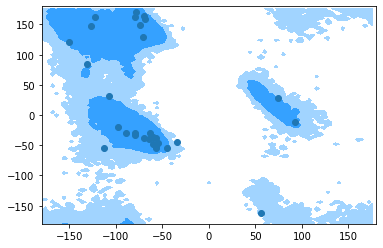

In [ ]:
import math
from MDAnalysis.analysis.data.filenames import Rama_ref
import matplotlib.pyplot as plt
# train [8000:40384-5024]
# val 
train_data = np.load("omega_train_notlong.npy", allow_pickle=True)[40384-5024:]  #[:40384-5024]     #[64:128] [:448]
train_data = train_data[:,-160:,:]
b, l, d = train_data.shape
print(b, l, d)
# nans = np.any(np.isnan(train_data.reshape(-1, l*d)), axis=1)
# train_data = np.delete(train_data, np.argwhere(nans).squeeze(), axis=0)
# assert np.isnan(train_data).any() == 0
# b, l, d = train_data.shape
# print(b, l, d)
# change from prepadding to postpadding
for i in range(b):
    start = pad_len = np.where(train_data[i, :, 0]==21.)[0][0]
    train_data[i] = np.concatenate((train_data[i, start:, :], np.zeros((pad_len, 4))), axis=0)

idx = train_data[:,:,0] == 0.
train_data[idx] = np.array([[200., 200., 200., 200.]])
idx = train_data[:,:,0] == 21.
train_data[idx] = np.array([[21., 200., 200., 21.]])
idx = train_data[:,:,0] == 22.
train_data[idx] = np.array([[22., 22., 200., 200.]])
train_circle = np.zeros((b, l, 3))
for i in [0, 1, 2]:
    train_data[:,:,i+1] = (train_data[:,:,i+1]*(2*math.pi) - math.pi)/math.pi*180. + 180.
    train_circle[:,:,i] = np.rint(train_data[:,:,i+1]) #+ (i*366)

b, l, d = train_data.shape
train_data = train_circle.reshape(b, 160*3, 1).astype(np.int64)
idx = train_data[:,:,:] > 10000
train_data[idx] = 362
idx = train_data[:,:,:] == 7560
train_data[idx] = 363
idx = train_data[:,:,:] == 7920
train_data[idx] = 364

train_data = train_data[:,2:]

np.save("cath_val.npy", train_data)

for i in range(100,101):
    print(train_data[i].flatten())
    plt.clf()
    plt.axis([-180,180,-180,180])
    levels = [1, 17, 15000]
    colors = ['#A1D4FF', '#35A1FF']
    X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
    plt.contourf(X, Y, np.load(Rama_ref), levels=levels, colors=colors)
    plt.scatter(train_data[i, 1:90:3].flatten()-180, train_data[i, 2:90:3].flatten()-180)
    plt.show()

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

gpt_config = GPT2Config(vocab_size=365, n_positions=500, n_ctx=500, n_embd=256, n_layer=6,
                        n_head=2, activation_function='gelu_new', resid_pdrop=0.1, embd_pdrop=0.1,
                        attn_pdrop=0.1, layer_norm_epsilon=1e-05, initializer_range=0.02,
                        summary_type='cls_index', summary_use_proj=True, summary_activation=None,
                        summary_proj_to_labels=True, summary_first_dropout=0.1, bos_token_id=363,
                        eos_token_id=364)

model = GPT2LMHeadModel(gpt_config)
print(model.num_parameters())

4960512


In [ ]:
import os
import glob
import numpy as np
import random
import time
import datetime
import logging
logging.basicConfig(level=logging.INFO)
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.optim.lr_scheduler.CyclicLR as CyclicLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
from torch.autograd import Variable
from transformers import GPT2LMHeadModel, GPT2Config, AdamW
from transformers import TransfoXLLMHeadModel, TransfoXLConfig
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
# % matplotlib inline
import seaborn as sns
import math

seed_val = 1234
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def to_var(tensor):
    return Variable(tensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Uncomment for training

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = np.load("cath_train.npy", allow_pickle=True)
train_data = train_data[:,:45,:]
train_data = torch.from_numpy(np.array(train_data, dtype=np.int64))
train_dataset = TensorDataset(train_data)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

print("training length", len(train_dataloader), flush=True)

val_data = np.load("cath_val.npy", allow_pickle=True)
val_data = val_data[:,:45,:]
val_data = torch.from_numpy(np.array(val_data, dtype=np.int64))
val_dataset = TensorDataset(val_data)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

class MyDataParallel(nn.DataParallel):
    """
    Allow nn.DataParallel to call model's attributes.
    """
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

gpt_config = GPT2Config(vocab_size=365, n_positions=500, n_ctx=500, n_embd=256, n_layer=6,
                        n_head=2, activation_function='gelu_new', resid_pdrop=0.1, embd_pdrop=0.1,
                        attn_pdrop=0.1, layer_norm_epsilon=1e-05, initializer_range=0.02,
                        summary_type='cls_index', summary_use_proj=True, summary_activation=None,
                        summary_proj_to_labels=True, summary_first_dropout=0.1, bos_token_id=363,
                        eos_token_id=364)

def train_model(model=None, lr=None): #lr, eps
    if model is None:
        model = GPT2LMHeadModel(gpt_config)

    # model.load_state_dict(torch.load("gpt_longer_train.pt"))
    model.to(device)

    # model.to(device)
    if lr is None:
        lr = 3e-4
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-1, cycle_momentum=False)
    num_epochs = 400
    total_steps = 27360/32 * num_epochs
    # scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                         num_warmup_steps = 0, #total_steps//5,
    #                                         num_training_steps = total_steps)
    impatience = 0
    patience = 50
    train_loss = []
    best_loss = 1e7
    best_val_loss = 1e7
    val_loss = []

    try:
        for epoch_i in range(0, num_epochs):
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs), flush=True)
            t0 = time.time()

            total_loss = 0
            model.train()

            train_steps = 0

            for i, b_input_ids in enumerate(train_dataloader):
                batch = []
                for b in b_input_ids:
                    batch.append(b.numpy())
                batch = np.array(batch).squeeze(axis=0)  
                b_input_ids = torch.from_numpy(batch)
                b_input_ids = b_input_ids.to(device)

                b_input_ids = b_input_ids.type(torch.LongTensor).squeeze().to(device)
                # print(b_input_ids.shape)
                # for i in range(16):
                #     plt.clf()
                #     print("Generated: ", b_input_ids[i])
                #     plt.axis([-180,180,-180,180])
                #     levels = [1, 17, 15000]
                #     colors = ['#A1D4FF', '#35A1FF']
                #     X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
                #     plt.contourf(X, Y, np.load(Rama_ref), levels=levels, colors=colors)
                #     plt.scatter(b_input_ids[i, 0:90:3].cpu().numpy()-180, b_input_ids[i, 1:90:3].cpu().numpy()-180)
                #     plt.show()
                # return
                attn_mask = b_input_ids != 362

                model.zero_grad()
                outputs = model(input_ids=b_input_ids, attention_mask=attn_mask,
                                output_attentions=True, labels=b_input_ids)

                loss = outputs[0]
                import IPython ; IPython.embed() ; exit(1)
                if not np.isnan(loss.item()):
                    train_steps += 1
                    curr_loss = loss.item() 
                    
                    total_loss += curr_loss
                    if curr_loss < best_loss:
                        best_loss = curr_loss
                        torch.save(model.state_dict(), "gpt_cath_train.pt")

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                    optimizer.step()
                    scheduler.step()
                    if (i + 1) % 100 == 0:
                        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                            epoch_i + 1,
                            num_epochs,
                            i + 1,
                            total_steps,
                            loss.item()), flush=True
                          )

            avg_train_loss = total_loss / train_steps
            train_loss.append(avg_train_loss)

            print("  Training epoch took: {:}".format(format_time(time.time() - t0)), flush=True)
            print("  Training loss: {0:.2f}".format(avg_train_loss), flush=True)

            print("Running Validation...", flush=True)

            model.eval()

            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0

            for i, b_input_ids in enumerate(val_dataloader):
                batch = []
                for b in b_input_ids:
                    batch.append(b.numpy())
                batch = np.array(batch).squeeze(axis=0)
                b_input_ids = torch.from_numpy(batch)
                b_input_ids = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().to(device)
                attn_mask = b_input_ids != 362
                with torch.no_grad():
                    outputs = model(input_ids=b_input_ids, attention_mask=attn_mask, labels=b_input_ids)
                curr_val_loss = outputs[0]
                if not np.isnan(curr_val_loss.item()):
                    eval_loss += curr_val_loss.item() #/ seq_len
                    nb_eval_steps += 1

            if eval_loss < best_val_loss:
                best_val_loss = eval_loss
                torch.save(model.state_dict(), "gpt_cath_val.pt")
            else:
                impatience += 1
            avg_val_loss = eval_loss/nb_eval_steps
            val_loss.append(avg_val_loss)
            print("  Validation loss: {0:.2f}".format(avg_val_loss), flush=True)
            # print("  Validation took: {:}".format(format_time(time.time() - t0)))

            # if impatience > patience:
            #     print("Stopping early because validation loss not improving after {} epochs".format(patience))
            #     return train_loss, val_loss, best_val_loss

        print("Training complete.", flush=True)
    except KeyboardInterrupt:
        print("Early exit from training.", flush=True)
        torch.save(model.state_dict(), "last_backprop.pt")
        return train_loss, val_loss, best_val_loss
    return train_loss, val_loss, best_val_loss


def plot_loss(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(train_loss, 'b-o')
    plt.plot(val_loss, 'r-o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("gpt_cath.png", dpi=200)

train_loss, val_loss, _ = train_model()
plot_loss(train_loss, val_loss)


training length 855
======== Epoch 1 / 400 ========
Python 3.6.9 (default, Jul 17 2020, 12:50:27) 
Type "copyright", "credits" or "license" for more information.

IPython 5.5.0 -- An enhanced Interactive Python.
?         -> Introduction and overview of IPython's features.
%quickref -> Quick reference.
help      -> Python's own help system.
object?   -> Details about 'object', use 'object??' for extra details.

In [1]: len(outputs)
Out[1]: 4

In [2]: attn = outputs[-1]

In [3]: len(attn)
Out[3]: 6

In [4]: f = attn[0]

In [5]: f.shape
Out[5]: torch.Size([32, 2, 45, 45])

In [6]: f
Out[6]: 
tensor([[[[1.1111, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.5810, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3144, 0.4866, 0.3101,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0261, 0.0287, 0.0252,  ..., 0.0232, 0.0000, 0.0000],
          [0.0243, 0.0262, 0.0000,  ..., 0.0257, 0.0245, 0.0000],
          [0.0225, 0.0241, 0.0000,  ..., 0.0257, 0.0259, 0

### Autoregress

In [ ]:
!pip install MDAnalysis
from MDAnalysis.analysis.data.filenames import Rama_ref

     |████████████████████████████████| 19.6MB 1.3MB/s 
     |████████████████████████████████| 2.3MB 48.2MB/s 
     |████████████████████████████████| 2.0MB 52.5MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 307kB 42.7MB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-1.0.0-cp36-cp36m-linux_x86_64.whl size=4553738 sha256=aca6ee0481295b9535727841caefc1ed4d3048b14a100acbcb284c7766e31143
  Stored in directory: /root/.cache/pip/wheels/00/76/c9/b13be0d6f29176526e2062225904dab9c2a1f6bbcbe3a38bbc
Successfully built MDAnalysis
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


seed shape torch.Size([32, 135])
Generated:  [0, 0, 363, 43, 312, 359, 95, 330, 358, 97, 346, 359, 119, 144, 360, 118, 142, 359, 111, 138, 359, 116, 145, 360, 117, 141, 359, 114, 138, 360, 116, 131, 1, 109, 154, 359, 113, 134, 360, 106, 150, 359, 115, 147, 359, 120, 146, 359, 107, 141, 359, 120, 142, 1, 113, 171, 358, 104, 163, 0, 27, 251, 1, 119, 134, 1, 120, 135, 360, 117, 136, 359, 112, 142, 360, 119, 138, 360, 117, 127, 1, 125, 135, 1, 114, 135, 360, 115, 138, 360, 113, 142, 359, 113, 143, 358, 118, 143, 358, 128, 138, 358, 95, 187, 358, 304, 305, 303, 299, 305, 299, 299, 305, 304, 354, 358, 305, 360, 359, 359, 82, 357, 357, 359, 357, 359, 360, 359, 325, 360, 325, 360, 359, 359, 360, 0, 360, 359, 360, 0, 359, 358, 360, 360, 359, 359, 357, 359, 359, 360, 360, 357, 360, 359, 359, 358, 359, 360, 0, 360, 357, 359, 359, 359, 357, 359, 359, 360, 359, 359, 357, 359, 0, 359, 360, 357, 0, 359, 359, 0]


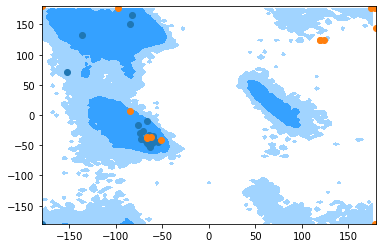

Generated:  [0, 0, 363, 90, 329, 6, 48, 313, 355, 116, 337, 354, 125, 133, 358, 118, 139, 353, 114, 144, 355, 118, 136, 356, 130, 130, 355, 129, 131, 357, 116, 141, 358, 114, 145, 353, 119, 156, 354, 28, 318, 93, 352, 263, 181, 356, 105, 325, 356, 78, 322, 353, 40, 304, 7, 45, 300, 352, 70, 300, 2, 83, 191, 357, 104, 0, 354, 86, 342, 3, 145, 128, 360, 148, 121, 357, 141, 121, 360, 147, 119, 4, 138, 135, 359, 135, 124, 1, 356, 310, 289, 321, 358, 126, 1, 131, 1, 1, 228, 1, 231, 227, 227, 228, 231, 228, 228, 227, 4, 1, 9, 96, 25, 7, 103, 103, 358, 114, 23, 135, 135, 152, 103, 23, 23, 135, 23, 103, 135, 103, 135, 23, 23, 23, 23, 0, 23, 58, 23, 58, 23, 58, 23, 58, 23, 58, 23, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


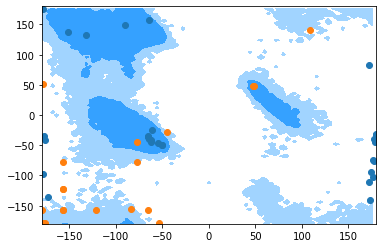

Generated:  [0, 0, 363, 135, 131, 359, 114, 132, 0, 113, 142, 360, 119, 139, 0, 107, 137, 360, 120, 126, 358, 122, 135, 0, 123, 145, 0, 116, 152, 360, 99, 165, 8, 93, 315, 356, 19, 274, 2, 22, 326, 2, 117, 160, 358, 71, 206, 357, 48, 313, 360, 126, 303, 1, 115, 321, 358, 74, 300, 0, 93, 137, 358, 343, 2, 359, 50, 353, 2, 20, 293, 360, 115, 119, 359, 227, 243, 359, 273, 57, 0, 79, 153, 359, 97, 292, 358, 97, 317, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 358, 304, 1, 352, 354, 352, 352, 355, 304, 5, 352, 352, 349, 349, 348, 347, 347, 347, 347, 46, 347, 347, 347, 347, 46, 46, 46, 46, 46, 46, 46, 46, 46, 0, 46, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


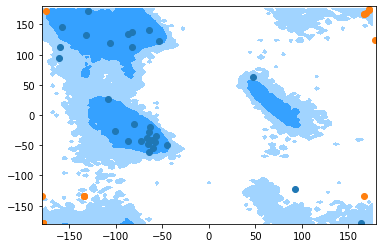

Generated:  [0, 0, 363, 64, 307, 356, 98, 323, 3, 49, 355, 2, 29, 322, 356, 64, 279, 357, 80, 219, 2, 131, 128, 358, 354, 322, 358, 264, 136, 1, 27, 358, 360, 74, 313, 357, 58, 288, 5, 87, 320, 359, 32, 7, 358, 31, 327, 2, 56, 309, 357, 49, 309, 10, 242, 47, 355, 84, 172, 10, 89, 333, 353, 92, 289, 6, 71, 202, 1, 51, 307, 352, 122, 295, 4, 125, 330, 359, 56, 300, 3, 75, 296, 354, 55, 335, 360, 101, 335, 355, 239, 20, 347, 347, 317, 348, 316, 308, 289, 308, 317, 317, 308, 298, 308, 305, 308, 298, 305, 304, 306, 317, 312, 220, 307, 347, 232, 58, 58, 360, 13, 13, 13, 13, 13, 13, 360, 2, 360, 13, 360, 360, 360, 360, 13, 0, 360, 360, 330, 360, 360, 360, 114, 360, 360, 360, 347, 360, 360, 360, 360, 13, 360, 360, 13, 360, 360, 2, 114, 360, 330, 360, 347, 360, 360, 360, 360, 103, 347, 360, 347, 360, 114, 360, 2, 360, 360, 360, 360, 360]


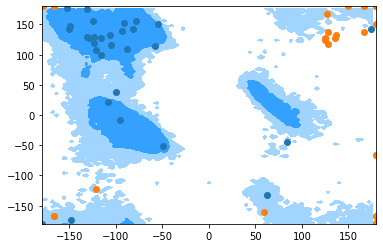

Generated:  [0, 0, 363, 271, 0, 303, 278, 2, 293, 267, 2, 305, 269, 1, 300, 270, 1, 305, 269, 0, 301, 266, 360, 302, 278, 1, 305, 278, 359, 302, 290, 355, 300, 86, 3, 232, 63, 357, 233, 95, 359, 310, 306, 1, 275, 312, 3, 260, 83, 360, 305, 78, 359, 304, 81, 3, 278, 69, 358, 276, 318, 3, 80, 217, 2, 257, 103, 1, 237, 94, 1, 288, 116, 359, 231, 130, 0, 316, 282, 356, 278, 276, 357, 273, 94, 5, 265, 66, 357, 282, 3, 3, 3, 3, 3, 64, 3, 60, 9, 9, 1, 60, 64, 2, 10, 297, 4, 2, 1, 1, 324, 65, 3, 3, 86, 200, 3, 80, 359, 359, 137, 137, 3, 334, 200, 359, 334, 334, 334, 334, 334, 334, 359, 137, 334, 0, 334, 359, 334, 359, 359, 334, 3, 137, 334, 359, 359, 334, 3, 359, 359, 334, 3, 137, 334, 359, 334, 3, 334, 334, 334, 3, 359, 359, 334, 334, 3, 137, 3, 334, 334, 359, 334, 3, 334, 359, 334, 359, 334, 359]


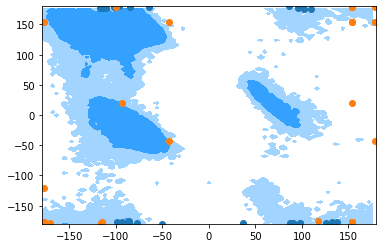

Generated:  [0, 0, 363, 64, 326, 17, 56, 342, 344, 97, 1, 4, 103, 314, 350, 74, 307, 358, 95, 313, 7, 110, 327, 0, 74, 178, 355, 37, 323, 354, 46, 345, 352, 39, 332, 347, 52, 326, 4, 59, 302, 357, 82, 295, 342, 40, 296, 6, 62, 3, 356, 118, 127, 349, 103, 152, 17, 68, 310, 352, 46, 317, 7, 11, 323, 348, 58, 316, 353, 49, 299, 8, 76, 326, 1, 48, 305, 12, 46, 309, 1, 106, 306, 359, 56, 357, 5, 115, 333, 347, 39, 299, 299, 39, 299, 335, 324, 335, 5, 234, 322, 1, 227, 227, 228, 228, 228, 228, 1, 228, 227, 1, 228, 228, 1, 1, 320, 354, 231, 221, 357, 222, 231, 5, 297, 357, 5, 5, 5, 357, 0, 320, 5, 304, 5, 0, 66, 304, 5, 304, 5, 66, 304, 5, 304, 5, 304, 5, 21, 5, 304, 5, 123, 304, 5, 79, 304, 5, 123, 304, 5, 304, 5, 123, 304, 5, 304, 5, 79, 304, 5, 79, 304, 5, 123, 304, 5, 66, 304, 5]


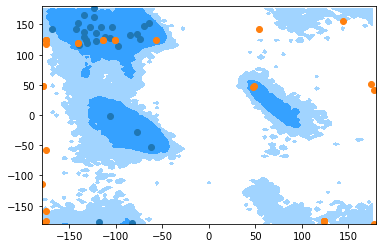

Generated:  [0, 0, 363, 62, 213, 359, 120, 151, 2, 73, 205, 357, 120, 307, 2, 87, 300, 359, 101, 141, 7, 15, 343, 2, 46, 320, 344, 68, 322, 179, 114, 330, 355, 107, 347, 4, 118, 302, 360, 260, 181, 359, 117, 325, 357, 80, 303, 9, 42, 340, 353, 109, 348, 20, 94, 185, 348, 61, 203, 9, 114, 308, 358, 108, 344, 351, 82, 292, 9, 73, 298, 5, 72, 304, 1, 70, 301, 2, 93, 334, 1, 112, 150, 358, 41, 327, 358, 121, 323, 353, 119, 320, 119, 343, 125, 234, 237, 237, 237, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 232, 354, 228, 231, 230, 232, 232, 5, 230, 233, 0, 232, 233, 0, 0, 236, 5, 122, 125, 0, 0, 21, 0, 21, 0, 21, 0, 21, 0, 123, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


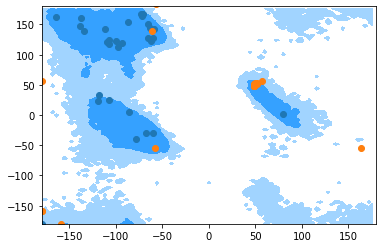

Generated:  [0, 0, 363, 354, 125, 155, 0, 81, 183, 358, 105, 323, 2, 59, 335, 359, 114, 321, 1, 348, 287, 9, 140, 139, 0, 131, 126, 356, 136, 123, 359, 144, 125, 359, 122, 316, 359, 325, 219, 39, 333, 233, 35, 336, 251, 26, 330, 257, 24, 326, 257, 15, 338, 43, 339, 328, 83, 345, 333, 244, 29, 327, 233, 36, 323, 223, 35, 325, 224, 48, 336, 228, 45, 332, 217, 39, 326, 240, 32, 325, 305, 342, 28, 115, 329, 323, 263, 358, 337, 10, 342, 257, 257, 359, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 355, 307, 1, 300, 306, 2, 0, 308, 360, 301, 308, 360, 302, 356, 357, 281, 62, 356, 310, 360, 0, 360, 308, 308, 6, 0, 360, 359, 0, 360, 0, 0, 359, 0, 308, 0, 360, 6, 0, 325, 325, 359, 329, 359, 329, 359, 360, 308, 356, 62, 0, 0, 50, 0, 359, 325, 359, 62, 6, 356, 325, 6, 325, 359, 0, 308, 6, 356, 52, 308, 6, 0, 50]


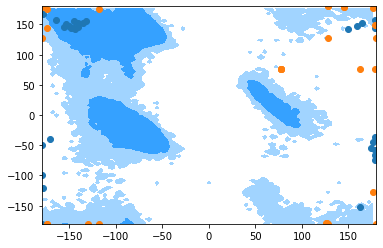

Generated:  [0, 0, 363, 88, 185, 358, 43, 339, 358, 22, 337, 358, 83, 306, 1, 6, 358, 354, 105, 307, 355, 109, 325, 360, 46, 347, 357, 85, 11, 2, 107, 177, 0, 74, 187, 3, 246, 218, 359, 66, 317, 358, 108, 348, 355, 77, 291, 358, 113, 340, 5, 32, 331, 356, 62, 163, 2, 44, 324, 357, 116, 142, 1, 122, 138, 359, 124, 135, 1, 109, 141, 359, 118, 137, 359, 117, 129, 1, 122, 133, 1, 114, 130, 2, 112, 147, 359, 109, 163, 358, 112, 113, 359, 112, 66, 358, 307, 298, 297, 298, 306, 1, 315, 302, 308, 332, 312, 304, 304, 1, 303, 304, 302, 305, 358, 354, 5, 104, 358, 357, 112, 360, 359, 112, 360, 360, 357, 357, 357, 359, 112, 357, 112, 112, 357, 0, 360, 357, 112, 359, 112, 353, 359, 112, 359, 113, 112, 353, 112, 357, 357, 360, 112, 357, 112, 357, 357, 112, 357, 112, 357, 359, 112, 353, 357, 112, 357, 357, 113, 112, 357, 360, 357, 357, 112, 359, 357, 357, 112, 357]


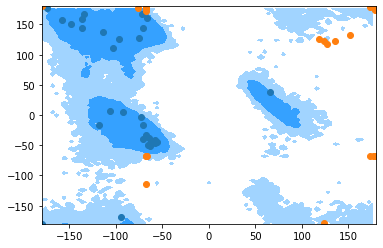

Generated:  [0, 0, 363, 95, 161, 357, 115, 159, 357, 102, 128, 359, 119, 139, 359, 120, 139, 359, 111, 130, 360, 124, 132, 359, 116, 132, 360, 122, 142, 359, 112, 138, 358, 118, 127, 359, 120, 147, 358, 115, 143, 1, 99, 145, 359, 99, 272, 0, 54, 291, 3, 25, 334, 359, 128, 144, 2, 64, 208, 356, 57, 307, 359, 133, 307, 2, 111, 313, 355, 74, 309, 2, 74, 170, 359, 315, 7, 359, 62, 353, 356, 40, 283, 360, 85, 168, 360, 110, 266, 0, 1, 359, 261, 1, 0, 0, 0, 0, 0, 359, 356, 356, 353, 353, 348, 352, 354, 352, 357, 354, 352, 9, 17, 1, 117, 170, 358, 113, 113, 1, 107, 261, 359, 113, 334, 359, 107, 358, 1, 107, 132, 1, 1, 334, 359, 0, 28, 359, 0, 261, 1, 261, 0, 107, 359, 1, 358, 359, 359, 107, 0, 77, 1, 1, 360, 359, 113, 132, 358, 107, 358, 359, 113, 359, 107, 1, 113, 360, 1, 360, 28, 0, 113, 358, 28, 1, 358, 251, 0, 28]


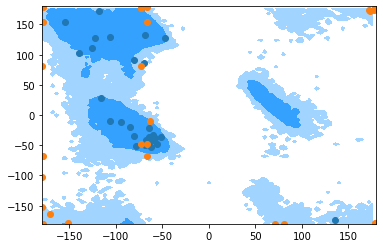

Generated:  [0, 0, 363, 69, 160, 2, 120, 137, 6, 114, 129, 356, 122, 141, 6, 110, 135, 1, 107, 149, 356, 123, 140, 2, 108, 143, 0, 110, 142, 0, 109, 138, 3, 110, 138, 0, 88, 186, 359, 229, 227, 358, 102, 300, 352, 127, 304, 3, 54, 335, 349, 73, 296, 351, 80, 305, 358, 77, 303, 4, 99, 347, 5, 117, 174, 359, 69, 197, 2, 266, 156, 4, 126, 318, 5, 69, 299, 357, 74, 329, 3, 45, 328, 355, 335, 28, 357, 59, 319, 358, 88, 316, 354, 97, 316, 354, 120, 316, 352, 22, 316, 2, 4, 306, 1, 305, 358, 303, 1, 5, 5, 116, 324, 7, 87, 88, 88, 88, 88, 88, 88, 258, 5, 88, 299, 360, 63, 303, 2, 45, 219, 2, 238, 88, 227, 0, 41, 5, 16, 39, 5, 33, 16, 23, 10, 0, 41, 6, 87, 10, 7, 233, 14, 7, 33, 10, 63, 24, 5, 16, 11, 7, 39, 6, 45, 3, 88, 9, 14, 7, 41, 360, 30, 7, 0, 52, 303, 0, 45, 3]


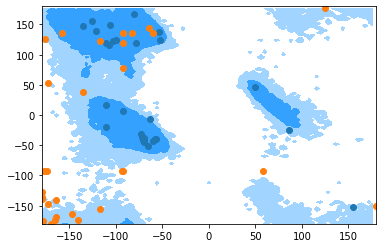

Generated:  [0, 0, 363, 87, 280, 2, 115, 140, 1, 116, 140, 354, 115, 146, 360, 116, 153, 358, 122, 140, 360, 112, 143, 355, 119, 136, 360, 121, 132, 1, 120, 144, 5, 98, 158, 14, 48, 168, 14, 46, 161, 7, 108, 155, 358, 118, 144, 358, 83, 158, 10, 51, 208, 358, 128, 317, 360, 253, 187, 8, 260, 189, 360, 87, 18, 2, 33, 282, 4, 115, 154, 7, 91, 131, 4, 49, 266, 17, 120, 155, 357, 112, 146, 15, 86, 246, 1, 99, 359, 359, 155, 155, 155, 155, 1, 299, 1, 4, 9, 1, 10, 10, 9, 4, 9, 306, 355, 301, 301, 305, 4, 355, 348, 352, 352, 354, 320, 324, 331, 74, 46, 101, 101, 101, 46, 49, 101, 99, 49, 26, 51, 26, 101, 101, 99, 0, 106, 334, 314, 340, 39, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


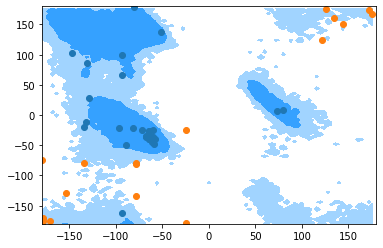

Generated:  [0, 0, 363, 338, 322, 98, 352, 331, 31, 348, 336, 241, 36, 330, 277, 9, 323, 280, 0, 338, 32, 344, 313, 30, 328, 327, 60, 340, 328, 104, 24, 334, 87, 346, 317, 63, 332, 323, 223, 30, 354, 353, 347, 326, 11, 330, 317, 92, 3, 324, 244, 20, 331, 248, 352, 345, 20, 351, 327, 14, 336, 323, 31, 330, 309, 250, 103, 138, 173, 120, 358, 259, 89, 2, 268, 68, 1, 292, 74, 355, 309, 269, 360, 308, 287, 356, 278, 284, 356, 60, 24, 24, 24, 24, 0, 0, 1, 7, 7, 349, 1, 352, 1, 349, 352, 352, 352, 9, 349, 4, 2, 1, 1, 60, 24, 24, 24, 38, 24, 5, 24, 60, 317, 360, 142, 142, 357, 142, 116, 116, 116, 8, 24, 84, 117, 0, 84, 24, 117, 142, 117, 24, 360, 60, 24, 24, 24, 360, 84, 60, 5, 60, 84, 60, 117, 24, 5, 117, 127, 84, 89, 60, 360, 24, 117, 142, 24, 360, 24, 60, 360, 84, 24, 24, 116, 89, 24, 360, 24, 1]


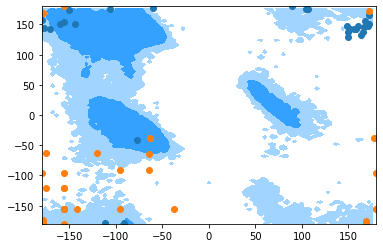

Generated:  [0, 0, 363, 33, 319, 2, 106, 310, 359, 107, 332, 1, 44, 322, 357, 61, 300, 0, 78, 312, 359, 56, 285, 0, 72, 339, 360, 344, 349, 0, 105, 351, 1, 119, 310, 358, 259, 194, 0, 100, 168, 359, 282, 194, 359, 122, 135, 1, 123, 135, 360, 113, 134, 1, 117, 138, 1, 114, 146, 360, 110, 137, 360, 114, 136, 359, 114, 129, 359, 123, 148, 359, 98, 148, 359, 112, 129, 1, 98, 162, 1, 247, 225, 1, 71, 3, 358, 91, 334, 1, 133, 133, 1, 132, 143, 1, 124, 322, 1, 1, 355, 358, 4, 9, 306, 3, 355, 351, 357, 3, 62, 0, 169, 169, 169, 1, 114, 133, 1, 133, 117, 133, 1, 133, 133, 1, 133, 133, 169, 169, 133, 169, 169, 169, 133, 0, 132, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


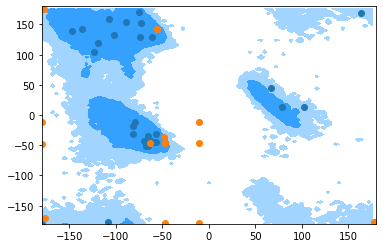

Generated:  [0, 0, 363, 119, 332, 8, 121, 305, 11, 110, 322, 350, 117, 332, 351, 116, 335, 1, 108, 345, 6, 122, 144, 3, 104, 176, 352, 66, 202, 351, 260, 199, 2, 108, 345, 2, 118, 333, 351, 109, 324, 0, 100, 310, 358, 49, 353, 357, 112, 165, 357, 98, 152, 6, 67, 171, 343, 187, 110, 7, 117, 159, 2, 78, 190, 346, 112, 302, 1, 103, 253, 7, 119, 159, 6, 97, 173, 4, 44, 230, 4, 107, 175, 359, 243, 202, 5, 21, 345, 2, 66, 240, 2, 66, 229, 2, 233, 224, 359, 223, 223, 359, 355, 324, 356, 355, 351, 352, 358, 355, 358, 62, 243, 235, 243, 240, 240, 240, 240, 240, 2, 58, 53, 0, 66, 240, 0, 58, 240, 58, 240, 240, 53, 58, 58, 0, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]


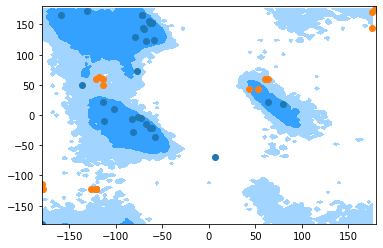

Generated:  [0, 0, 363, 359, 33, 358, 4, 140, 137, 359, 134, 123, 360, 136, 132, 2, 141, 118, 0, 130, 138, 357, 137, 131, 355, 136, 120, 4, 131, 136, 6, 94, 150, 2, 258, 7, 356, 17, 303, 357, 47, 130, 359, 331, 263, 6, 323, 42, 343, 331, 84, 335, 331, 44, 355, 319, 42, 336, 325, 110, 4, 5, 115, 340, 2, 286, 305, 360, 67, 70, 360, 286, 81, 2, 305, 83, 355, 255, 111, 2, 240, 113, 3, 54, 276, 1, 279, 18, 359, 52, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 313, 309, 5, 59, 323, 5, 55, 7, 7, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 21, 337, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


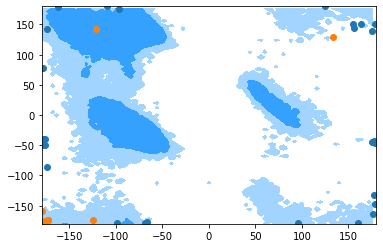

Generated:  [0, 0, 363, 83, 287, 2, 108, 326, 345, 106, 340, 3, 120, 124, 357, 112, 149, 356, 119, 135, 358, 110, 146, 356, 120, 136, 0, 115, 136, 359, 113, 138, 359, 119, 137, 358, 115, 133, 359, 120, 145, 358, 98, 176, 351, 271, 204, 358, 96, 156, 360, 119, 299, 1, 247, 195, 356, 113, 308, 9, 229, 210, 357, 264, 182, 0, 87, 295, 4, 116, 339, 2, 129, 140, 3, 118, 148, 355, 116, 138, 1, 108, 135, 354, 120, 135, 357, 122, 136, 1, 155, 155, 0, 141, 352, 352, 149, 352, 352, 1, 5, 354, 149, 1, 1, 136, 352, 149, 0, 0, 5, 54, 162, 176, 115, 162, 358, 118, 161, 118, 30, 161, 358, 126, 161, 161, 161, 161, 359, 161, 161, 161, 161, 161, 161, 0, 161, 118, 162, 358, 161, 161, 359, 118, 162, 359, 162, 358, 161, 359, 162, 358, 161, 358, 161, 359, 118, 161, 359, 162, 358, 161, 162, 359, 97, 169, 359, 118, 161, 176, 359, 162, 359, 169, 359, 162, 359, 118, 161, 162]


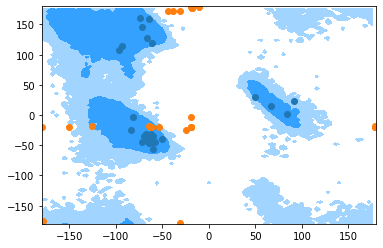

Generated:  [0, 0, 363, 60, 309, 10, 44, 315, 351, 71, 313, 354, 76, 307, 358, 62, 331, 352, 336, 342, 358, 127, 332, 352, 123, 311, 3, 269, 183, 3, 108, 155, 358, 298, 197, 1, 120, 127, 1, 118, 145, 358, 115, 134, 2, 104, 154, 354, 125, 142, 359, 120, 131, 357, 121, 133, 1, 114, 137, 357, 125, 133, 2, 108, 146, 357, 110, 139, 4, 75, 171, 2, 239, 223, 356, 64, 331, 356, 106, 332, 355, 87, 310, 352, 72, 282, 3, 68, 293, 359, 97, 130, 1, 60, 344, 1, 306, 327, 309, 322, 312, 1, 306, 349, 355, 78, 314, 1, 352, 344, 349, 9, 312, 9, 58, 58, 357, 105, 1, 1, 118, 118, 3, 101, 267, 2, 97, 168, 1, 2, 267, 97, 3, 119, 97, 0, 101, 183, 3, 118, 149, 360, 105, 2, 105, 149, 3, 97, 105, 168, 2, 267, 2, 101, 330, 2, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]


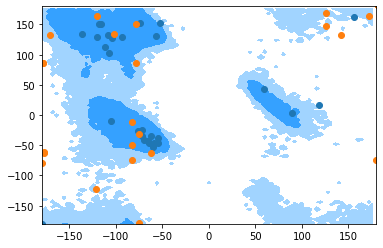

Generated:  [0, 0, 363, 100, 334, 359, 114, 319, 2, 84, 322, 1, 50, 311, 358, 72, 303, 0, 80, 300, 358, 59, 290, 0, 12, 354, 358, 37, 240, 1, 32, 258, 1, 146, 121, 1, 116, 150, 359, 109, 133, 0, 116, 143, 359, 121, 136, 360, 108, 136, 359, 121, 141, 360, 117, 140, 359, 117, 136, 360, 118, 140, 0, 113, 153, 359, 112, 155, 360, 105, 171, 0, 55, 287, 0, 119, 150, 1, 96, 188, 357, 45, 325, 1, 29, 331, 359, 97, 302, 1, 125, 152, 125, 125, 124, 124, 355, 134, 348, 127, 124, 1, 313, 351, 352, 5, 352, 118, 1, 355, 320, 1, 349, 4, 117, 176, 176, 118, 176, 5, 47, 212, 359, 74, 246, 0, 0, 43, 198, 360, 136, 0, 125, 125, 0, 0, 125, 1, 125, 1, 125, 1, 125, 1, 125, 1, 125, 1, 125, 1, 123, 310, 346, 123, 310, 356, 113, 310, 341, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


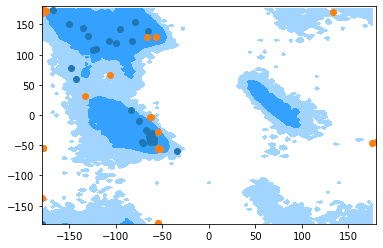

Generated:  [0, 0, 363, 111, 334, 340, 48, 201, 358, 85, 231, 349, 88, 306, 357, 122, 316, 354, 123, 144, 359, 115, 145, 358, 109, 130, 4, 123, 143, 360, 118, 153, 360, 86, 187, 360, 99, 253, 5, 54, 324, 358, 127, 132, 1, 115, 159, 359, 86, 137, 5, 100, 149, 5, 94, 270, 17, 107, 156, 358, 88, 185, 352, 127, 308, 358, 126, 320, 8, 121, 133, 358, 121, 144, 356, 109, 137, 358, 126, 144, 359, 112, 151, 359, 69, 188, 10, 117, 132, 354, 159, 151, 159, 151, 308, 298, 306, 360, 298, 352, 136, 132, 360, 134, 132, 352, 141, 139, 1, 139, 138, 352, 132, 109, 109, 109, 80, 159, 151, 320, 116, 159, 116, 159, 146, 151, 116, 159, 151, 159, 159, 159, 116, 159, 159, 0, 112, 159, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


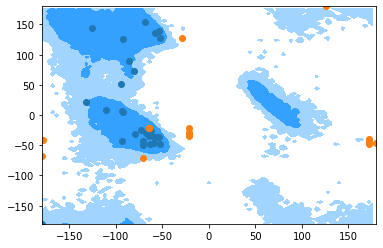

Generated:  [0, 0, 363, 77, 166, 346, 92, 164, 338, 108, 355, 360, 50, 325, 7, 69, 327, 358, 39, 353, 352, 35, 348, 343, 28, 343, 343, 79, 322, 8, 25, 5, 4, 52, 326, 355, 132, 320, 0, 258, 167, 353, 131, 298, 359, 83, 293, 9, 48, 347, 2, 48, 303, 356, 78, 315, 3, 44, 308, 346, 56, 318, 3, 27, 347, 357, 118, 324, 4, 111, 323, 2, 142, 135, 5, 99, 176, 354, 60, 201, 16, 125, 156, 6, 63, 183, 356, 90, 308, 10, 320, 320, 320, 4, 10, 10, 78, 10, 358, 306, 358, 263, 269, 351, 354, 306, 348, 354, 324, 358, 306, 77, 77, 85, 85, 84, 1, 72, 356, 354, 99, 351, 353, 93, 131, 1, 85, 304, 0, 87, 308, 0, 0, 5, 320, 0, 320, 357, 298, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


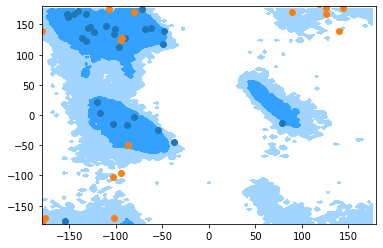

Generated:  [0, 0, 363, 96, 303, 356, 58, 341, 4, 106, 307, 356, 110, 303, 1, 101, 157, 7, 23, 349, 357, 121, 139, 4, 114, 144, 360, 153, 18, 286, 358, 147, 121, 1, 145, 123, 358, 141, 128, 1, 136, 127, 358, 142, 128, 359, 120, 320, 359, 327, 221, 38, 333, 236, 34, 326, 289, 349, 329, 245, 27, 322, 114, 9, 321, 231, 13, 321, 35, 339, 332, 44, 337, 320, 27, 324, 339, 239, 29, 325, 233, 35, 329, 220, 40, 330, 222, 39, 328, 231, 42, 325, 360, 325, 3, 3, 4, 9, 106, 1, 352, 99, 1, 351, 302, 305, 348, 351, 352, 355, 305, 358, 358, 109, 351, 50, 319, 360, 358, 128, 360, 325, 144, 360, 325, 114, 114, 154, 360, 360, 360, 360, 114, 144, 360, 0, 117, 360, 42, 144, 360, 121, 144, 325, 114, 325, 325, 360, 128, 114, 360, 114, 121, 24, 121, 360, 24, 144, 360, 121, 24, 325, 144, 13, 128, 360, 128, 117, 144, 114, 360, 360, 360, 128, 360, 121, 144, 144, 360, 117]


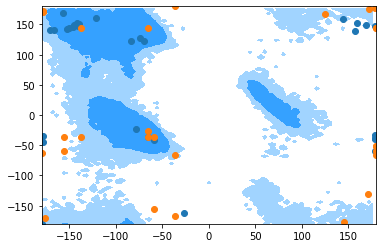

Generated:  [0, 0, 363, 26, 258, 339, 80, 227, 357, 132, 140, 355, 136, 137, 5, 82, 184, 7, 89, 323, 5, 103, 337, 7, 114, 146, 6, 95, 156, 348, 113, 122, 1, 141, 119, 10, 91, 222, 353, 233, 192, 358, 107, 338, 351, 107, 334, 17, 17, 339, 349, 80, 306, 356, 133, 134, 3, 118, 136, 359, 114, 149, 357, 116, 128, 3, 125, 130, 360, 125, 139, 352, 130, 116, 2, 127, 146, 355, 113, 143, 353, 124, 139, 3, 110, 132, 352, 132, 126, 357, 87, 110, 322, 87, 181, 136, 138, 138, 136, 358, 136, 136, 358, 139, 140, 357, 134, 138, 359, 143, 143, 358, 136, 135, 1, 118, 149, 353, 87, 87, 87, 322, 325, 87, 325, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 0, 87, 320, 89, 65, 58, 83, 58, 83, 58, 87, 299, 58, 83, 58, 87, 24, 87, 62, 58, 87, 159, 87, 62, 58, 87, 24, 83, 58, 87, 299, 58, 83, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


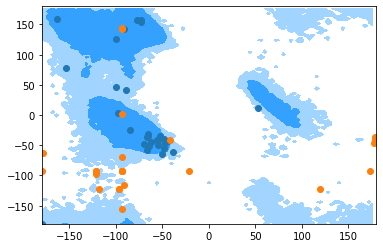

Generated:  [0, 0, 363, 116, 150, 1, 110, 142, 359, 112, 133, 356, 120, 140, 358, 120, 136, 358, 118, 137, 358, 114, 148, 357, 107, 143, 353, 118, 138, 358, 118, 127, 4, 122, 132, 6, 81, 152, 7, 53, 199, 353, 50, 335, 359, 28, 345, 354, 86, 303, 358, 74, 303, 356, 73, 308, 354, 56, 5, 322, 278, 196, 180, 176, 92, 174, 357, 315, 20, 3, 58, 319, 360, 37, 335, 356, 78, 309, 359, 55, 319, 357, 54, 304, 356, 75, 303, 4, 119, 120, 347, 50, 347, 50, 308, 2, 5, 0, 1, 1, 1, 1, 358, 1, 358, 1, 0, 360, 1, 2, 306, 1, 360, 304, 82, 82, 82, 78, 82, 50, 347, 316, 299, 82, 299, 298, 82, 82, 299, 50, 298, 298, 298, 50, 50, 0, 50, 82, 305, 347, 50, 82, 298, 82, 299, 299, 299, 357, 82, 299, 82, 305, 357, 50, 299, 82, 305, 7, 50, 305, 357, 50, 299, 357, 50, 298, 82, 82, 305, 82, 310, 299, 82, 299, 298, 50, 301, 347, 50, 299]


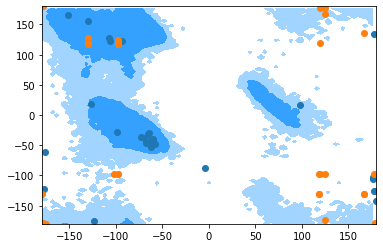

Generated:  [0, 0, 363, 3, 333, 8, 68, 318, 3, 55, 329, 352, 64, 319, 2, 116, 321, 343, 93, 274, 355, 131, 151, 358, 112, 154, 1, 52, 212, 359, 54, 312, 356, 57, 300, 355, 82, 271, 17, 67, 345, 0, 22, 326, 355, 57, 315, 355, 40, 313, 4, 93, 319, 348, 42, 344, 356, 82, 331, 354, 41, 308, 355, 91, 314, 351, 37, 342, 353, 89, 308, 342, 96, 294, 355, 78, 325, 5, 17, 345, 351, 37, 21, 357, 39, 309, 3, 102, 161, 10, 356, 263, 208, 355, 297, 3, 285, 9, 9, 10, 9, 1, 10, 5, 5, 4, 1, 3, 10, 3, 1, 3, 5, 5, 24, 315, 6, 53, 297, 356, 356, 306, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 315, 356, 0, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 356, 315, 359, 315, 359, 315, 359, 315, 356]


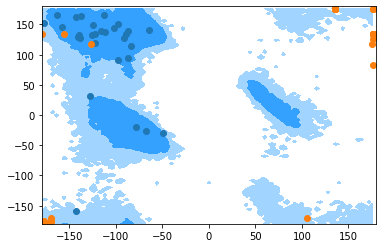

Generated:  [0, 0, 363, 114, 316, 359, 33, 305, 355, 68, 318, 3, 48, 290, 0, 93, 327, 356, 24, 342, 360, 288, 178, 358, 106, 326, 358, 8, 7, 357, 91, 304, 4, 52, 337, 359, 92, 329, 355, 120, 321, 2, 275, 166, 3, 99, 341, 357, 75, 325, 360, 30, 311, 0, 72, 309, 358, 73, 328, 1, 56, 324, 358, 57, 279, 359, 93, 304, 4, 67, 322, 2, 29, 347, 358, 260, 191, 357, 20, 353, 357, 101, 281, 4, 133, 136, 4, 106, 161, 1, 46, 3, 2, 100, 306, 4, 9, 5, 124, 1, 359, 1, 9, 316, 349, 349, 349, 1, 3, 138, 8, 127, 132, 5, 55, 327, 3, 92, 354, 354, 120, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 0, 46, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


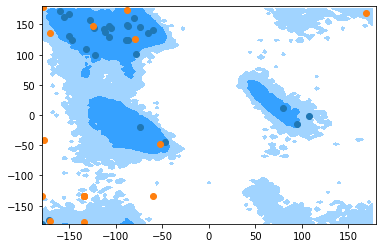

Generated:  [0, 0, 363, 92, 340, 1, 81, 328, 358, 106, 314, 359, 78, 322, 358, 47, 280, 2, 95, 313, 359, 68, 268, 2, 253, 55, 1, 98, 171, 1, 89, 311, 359, 69, 290, 1, 87, 310, 360, 11, 326, 3, 128, 153, 360, 74, 179, 358, 91, 342, 359, 120, 325, 4, 117, 324, 359, 77, 317, 359, 83, 310, 358, 67, 240, 1, 108, 7, 360, 319, 34, 0, 51, 358, 0, 98, 115, 360, 59, 340, 359, 92, 264, 360, 114, 119, 1, 27, 319, 1, 359, 163, 52, 359, 356, 298, 302, 354, 306, 308, 306, 349, 352, 351, 354, 355, 349, 355, 356, 352, 354, 339, 342, 347, 352, 352, 352, 352, 352, 344, 352, 324, 339, 347, 325, 337, 352, 337, 302, 356, 310, 302, 362, 362, 362, 0, 334, 352, 313, 356, 338, 339, 348, 339, 346, 339, 354, 339, 352, 302, 353, 331, 339, 341, 341, 356, 338, 358, 331, 341, 339, 341, 338, 352, 331, 347, 352, 315, 354, 331, 339, 352, 339, 339, 356, 309, 358, 334, 302, 354]


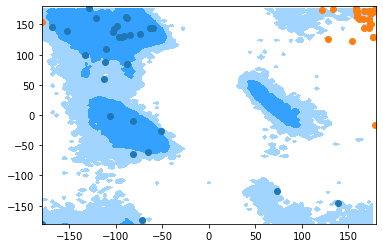

Generated:  [0, 0, 363, 43, 312, 0, 79, 351, 359, 5, 360, 358, 56, 337, 358, 49, 293, 360, 79, 296, 357, 97, 289, 3, 58, 343, 0, 114, 145, 1, 86, 216, 360, 287, 1, 360, 85, 314, 359, 64, 315, 1, 65, 319, 354, 79, 290, 0, 252, 320, 358, 92, 56, 1, 28, 5, 2, 132, 123, 1, 38, 0, 1, 126, 140, 0, 118, 129, 1, 111, 151, 1, 97, 150, 0, 109, 139, 0, 111, 138, 358, 115, 130, 359, 127, 128, 0, 122, 141, 0, 84, 89, 210, 1, 208, 230, 353, 220, 225, 4, 1, 302, 356, 1, 317, 357, 353, 307, 1, 357, 352, 354, 354, 343, 360, 25, 89, 89, 329, 1, 87, 84, 323, 84, 320, 323, 89, 320, 84, 84, 84, 84, 323, 323, 84, 0, 341, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


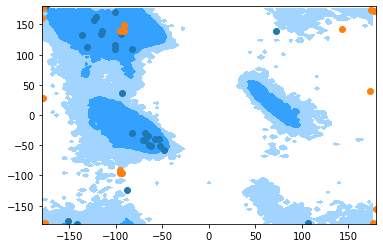

Generated:  [0, 0, 363, 114, 151, 356, 119, 131, 0, 120, 138, 358, 117, 140, 0, 114, 136, 4, 116, 134, 359, 118, 133, 354, 125, 130, 5, 117, 135, 4, 116, 140, 354, 121, 128, 6, 112, 148, 360, 115, 159, 358, 109, 156, 360, 70, 165, 356, 16, 343, 1, 114, 341, 1, 119, 143, 355, 125, 158, 358, 76, 190, 356, 68, 308, 5, 81, 337, 354, 124, 148, 2, 115, 137, 355, 125, 130, 4, 113, 138, 358, 125, 126, 5, 123, 128, 3, 120, 154, 1, 154, 154, 154, 3, 212, 1, 352, 306, 301, 304, 352, 298, 352, 356, 289, 298, 356, 304, 1, 304, 0, 0, 359, 359, 74, 334, 354, 352, 5, 5, 354, 345, 354, 354, 345, 345, 345, 345, 345, 354, 345, 345, 345, 311, 311, 0, 354, 354, 345, 354, 345, 354, 354, 354, 311, 5, 354, 345, 345, 3, 354, 3, 354, 3, 354, 354, 354, 130, 360, 354, 345, 351, 354, 354, 345, 351, 354, 345, 5, 311, 3, 3, 345, 354, 354, 130, 1, 354, 354, 5]


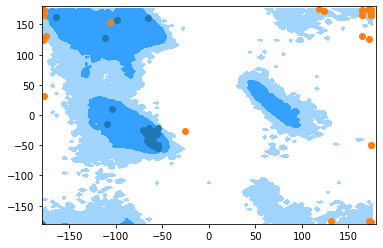

Generated:  [0, 0, 363, 26, 354, 2, 124, 140, 359, 115, 131, 359, 115, 143, 0, 117, 128, 359, 112, 148, 360, 116, 148, 359, 109, 133, 2, 113, 142, 3, 82, 157, 2, 254, 3, 359, 45, 298, 359, 54, 314, 3, 82, 179, 0, 56, 328, 1, 126, 315, 359, 39, 350, 359, 79, 306, 1, 111, 10, 0, 119, 160, 0, 76, 173, 359, 280, 189, 1, 88, 330, 359, 112, 303, 4, 40, 345, 355, 26, 347, 357, 243, 51, 1, 75, 252, 0, 252, 204, 0, 359, 245, 6, 6, 6, 6, 360, 4, 360, 1, 359, 360, 1, 325, 150, 1, 351, 325, 3, 359, 359, 352, 345, 353, 240, 239, 239, 270, 188, 5, 91, 157, 0, 82, 245, 6, 83, 129, 6, 6, 239, 6, 83, 240, 6, 0, 81, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


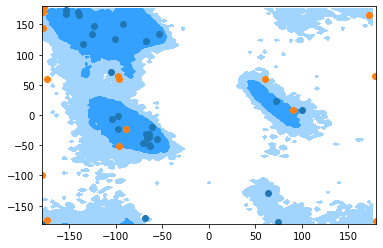

Generated:  [0, 0, 363, 107, 319, 4, 57, 317, 1, 105, 315, 359, 82, 296, 1, 132, 143, 352, 120, 132, 4, 111, 145, 355, 122, 134, 5, 115, 136, 5, 116, 135, 8, 109, 143, 353, 111, 141, 357, 116, 135, 360, 122, 143, 357, 114, 135, 356, 128, 134, 357, 116, 147, 4, 103, 140, 353, 129, 143, 6, 108, 150, 352, 122, 144, 358, 94, 130, 9, 67, 281, 180, 76, 187, 10, 134, 117, 10, 101, 157, 360, 113, 145, 1, 95, 148, 357, 121, 125, 356, 122, 122, 122, 122, 122, 360, 315, 352, 1, 358, 320, 358, 297, 317, 1, 1, 2, 0, 1, 1, 360, 360, 5, 5, 122, 122, 122, 122, 122, 122, 117, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 0, 122, 122, 122, 122, 122, 122, 122, 122, 117, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 117, 122, 122, 122, 122, 122, 122, 122, 122, 117, 122, 122, 117, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]


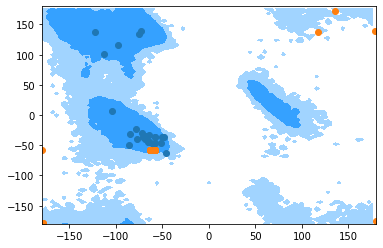

Generated:  [0, 0, 363, 94, 36, 9, 108, 339, 354, 74, 312, 9, 36, 326, 339, 72, 333, 355, 45, 314, 3, 29, 335, 344, 64, 316, 11, 42, 318, 357, 98, 354, 1, 121, 151, 1, 85, 201, 350, 254, 196, 1, 100, 322, 356, 57, 166, 1, 19, 336, 349, 37, 299, 356, 233, 224, 354, 251, 198, 349, 53, 355, 352, 106, 333, 1, 109, 157, 9, 68, 341, 355, 115, 342, 7, 121, 310, 352, 72, 284, 14, 118, 136, 358, 108, 152, 355, 115, 139, 359, 124, 157, 1, 113, 121, 3, 113, 118, 348, 308, 308, 358, 119, 308, 357, 119, 301, 356, 116, 301, 356, 118, 307, 316, 1, 314, 72, 62, 358, 173, 1, 105, 163, 0, 316, 163, 350, 124, 159, 316, 124, 316, 124, 336, 336, 0, 316, 316, 1, 336, 105, 316, 1, 124, 143, 1, 336, 316, 316, 360, 62, 299, 316, 124, 163, 1, 105, 336, 124, 151, 358, 124, 159, 105, 157, 124, 157, 1, 105, 316, 1, 316, 62, 299, 1, 336, 105, 173, 143, 316]


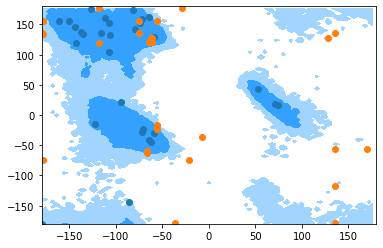

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict
import math
torch.set_printoptions(profile="full")
def autoregress(model, weights, seed=None, max_len=128):
    model.double()
    model.cuda()
    # original saved file with DataParallel

    # state_dict = torch.load(weights)

    state_dict = torch.load(weights)

    # state_dict = torch.load(weights, map_location=torch.device('cpu'))

    # # create new OrderedDict that does not contain `module.`
    # new_state_dict = OrderedDict()
    # for k, v in state_dict.items():
    #     name = k
    #     if k.startswith("transformer"):
    #         name = k[:12] + k[19:]
    #     new_state_dict[name] = v
    # # load params
    # model.load_state_dict(new_state_dict)

    model.load_state_dict(state_dict)
    model.eval()
    files = []
    if seed is None:
        # for i, (fnames, b_input_ids) in enumerate(train_dataloader):
        for i, b_input_ids in enumerate(train_dataloader):
            batch = []
            for b in b_input_ids:
                batch.append(b.numpy())
            batch = np.array(batch).squeeze(axis=0)  
            b_input_ids = torch.from_numpy(batch)
            b_input_ids = b_input_ids.to(device)

            seed = b_input_ids.type(torch.LongTensor).squeeze().to(device)
            seed = seed.to(device)
            break

    seed = seed.squeeze().cuda()
    print("seed shape", seed.shape)

    with torch.no_grad():
        seed = seed[:,:90].type(torch.LongTensor).squeeze().to(device)
        # gen = model.generate(seed, max_length=180, do_sample=False) #True, top_k=3)
        gen = model.generate(seed, max_length=180, do_sample=True, top_p=0.5)
        # print(gen.shape)
        # print(seed[0])
        # print(gen[0])
        # attn_mask = seed != 362
        # with torch.no_grad(): 
        #     outputs = model(input_ids=seed, attention_mask=attn_mask, labels=None)
        # print(outputs[0])
        # logits = outputs[0].cpu().numpy()
        # samples = np.argmax(logits, axis=2)
        # print(samples.shape)
        # return
        # for _ in range(60):
        #     # labels = seed[:,:,0].type(torch.LongTensor).squeeze().to(device)
        #     # coords = seed[:,:,1:].to(device)
        #     seed = seed.type(torch.LongTensor).squeeze().to(device)
        #     with torch.no_grad(): 
        #         outputs = model(input_ids=seed, labels=None)
        #     # coord_pred, mems, attentions = outputs
        #     coord_pred, _ = outputs
        #     print("seed", seed.shape)
        #     print("coord_pred", coord_pred.shape)
        #     # take softmax of coord_pred
        #     # coord_pred = torch.cat((torch.zeros(seed.shape[0], coord_pred.shape[1], 1).to(device).double(), coord_pred), 2)
        #     # print("coord pred", coord_pred.shape)
        #     # print("last of seed", seed[:,-2:,:])
        #     # print("concatenated", coord_pred[:,-2:,:])
        #     seed = torch.cat((seed, coord_pred[:,-1:,:]), 1)
        #     print("seed after cat", seed.shape)

        gen = gen.cpu().numpy()

        sns.reset_orig()
        for i in range(32):
            plt.clf()
            # import IPython ; IPython.embed() ; exit(1)
            # np.save("sample_{}.npy".format(i), seed)
            print("Generated: ", list(gen[i]))
            plt.axis([-180,180,-180,180])
            levels = [1, 17, 15000]
            colors = ['#A1D4FF', '#35A1FF']
            X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
            plt.contourf(X, Y, np.load(Rama_ref), levels=levels, colors=colors)
            # plt.scatter(seed[i, 0:90:3]-180, seed[i, 1:90:3]-180)
            # plt.scatter(samples[i, 2:89:3]-180, samples[i, 3:90:3]-180)
            # plt.scatter(phis[:-60], psis[:-60])
            # plt.scatter(phis[-60:], psis[-60:])
            
            plt.scatter(gen[i, 0:90:3]-180, gen[i, 1:90:3]-180)
            plt.scatter(gen[i, 90:-1:3]-180, gen[i, 91::3]-180)
            # plt.savefig("{}.png".format(i), dpi=200)
            plt.show()

model = GPT2LMHeadModel(gpt_config)
autoregress(model, "gpt_longer_train.pt")

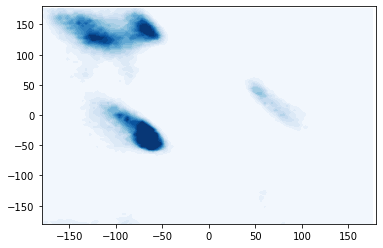

In [ ]:
plt.clf()
plt.axis([-180,180,-180,180])
levels = [1, 17, 15000]
colors = ['#A1D4FF', '#35A1FF']
X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
ref = np.load(Rama_ref)
ref[ref > 180] = 180
# plt.contourf(X, Y, ref, levels=levels, colors=colors)
plt.contourf(X, Y, ref, 20, cmap='Blues')
plt.savefig("ram.png", dpi=200)

(array([7.074e+03, 3.030e+02, 1.600e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([   0.  ,   14.09,   28.18, ..., 2789.82, 2803.91, 2818.  ]),
 <a list of 200 Patch objects>)

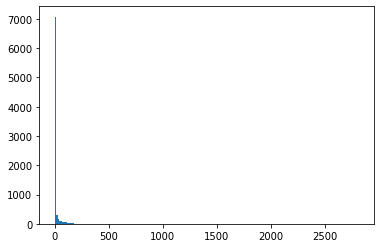

In [ ]:
a = np.load(Rama_ref).flatten()
plt.hist(a, bins=1020)

#### Hyperparameter tuning

In [ ]:
!pip install scikit-optimize==0.5.2
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
!pip install xgboost==0.90

import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

bds = [{'name': 'n', 'type': 'discrete', 'domain': (2,12)},  # n_head = n_layer = n_embed/32
       {'name': 'activ', 'type': 'discrete', 'domain': (0, 4)},  # activation function
       {'name': 'pdrop', 'type': 'continuous', 'domain': (0.1, 0.9)},
       {'name': 'lr', 'type': 'continuous', 'domain': (1e-5, 1e-2)}]  # embd_pdrop = attn_pdrop 
act_funcs = ["relu", "swish", "gelu", "tanh", "gelu_new"]

def bo_objective(parameters):
    p = parameters[0]

    gpt_config = GPT2Config(vocab_size=365, n_positions=30, n_ctx=30, n_embd=32*int(p[0]), n_layer=int(p[0]),
                        n_head=2, activation_function=act_funcs[int(p[1])], resid_pdrop=p[2], embd_pdrop=p[2],
                        attn_pdrop=p[2], layer_norm_epsilon=1e-05, initializer_range=0.02,
                        summary_type='cls_index', summary_use_proj=True, summary_activation=None,
                        summary_proj_to_labels=True, summary_first_dropout=0.1, bos_token_id=363,
                        eos_token_id=364)
    
    model = GPT_Protein(gpt_config)

    _, _, score = train_model(model=model, lr=p[3]) # best validation score
    print("Objective: ")
    print(score)
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=bo_objective, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='LCB',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

optimizer.run_optimization(max_iter=20)

y_bo = np.maximum.accumulate(-optimizer.Y).ravel() + 1

print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('BO');
plt.legend();

print(optimizer.X)